In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm


Using TensorFlow backend.


There is 1 csv file in the current version of the dataset:


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [ ]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


In [2]:
df_metric = pd.read_csv("./fight-dataset/metric_data.csv")
print(df_metric)

   Labels    Classes  Train_data  Test_data
0       1        Hit        3709        424
1       2       Kick        5420        530
2       3      Punch        8720        201
3       4       Push        9557        778
4       5  ridehorse       15620        820
5       6   shootgun        9004        828
6       7      stand       10384        875
7       8       wave        5634        465


In [3]:
df_dataset = pd.read_csv("./fight-dataset/actions (2)/actions/dataset.csv")
print(df_dataset.head())

    Framenames  LebelID
0     hit0.jpg        1
1     hit1.jpg        1
2    hit10.jpg        1
3   hit100.jpg        1
4  hit1000.jpg        1


In [4]:
print(df_dataset.loc[df_dataset["Framenames"] == 'hit4437.jpg']) #Test examples also annotated

       Framenames  LebelID
2753  hit4437.jpg        1


In [5]:
def check_data_dimensions(df_img_size):
    
    train_path = "./fight-dataset/actions (2)/actions/train"
    
    train_height = []
    train_width = []
    train_channel = []
    for dirname, _, filenames in os.walk(train_path):
        for filename in filenames:
            #print(os.path.join(dirname, filename))
            img_path = os.path.join(dirname, filename)
            print(img_path)
            
            img = cv2.imread(img_path)            
            height, width, channels = img.shape
            train_height.append(height)
            train_width.append(width)
            train_channel.append(channels)
    
    df_img_size['height'] = np.array(train_height)    
    df_img_size['width'] = np.array(train_width)
    df_img_size['channels'] = np.array(train_channel)
    
    df_img_size.to_csv('./img_sizes.csv')
    
    return df_img_size

#df_img_size = pd.DataFrame(columns = ['height','width','channels'])
#df_img_size = check_data_dimensions(df_img_size)


            
    
    

In [6]:
def image_preprocess(image):
    img = image.copy()
    img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA) #224,224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = np.expand_dims(img, axis=2)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

def prepare_list_of_files(path):
    file_list = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if '.png' or '.jpg' or '.jpeg' in filename:
                img_path = os.path.join(dirname, filename)
                file_list.append(filename)
                #print(img_path)
    return file_list

def prepare_images_array(path):
    images = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if '.png' or '.jpg' or '.jpeg' in filename:
                img_path = os.path.join(dirname, filename)
                image = cv2.imread(img_path)
                cleaned_img = image_preprocess(image)
                #height, width, channels = cleaned_img.shape
                #cleaned_img = cv2.resize(cleaned_img, (-1, height, width, channels), interpolation = cv2.INTER_AREA)
                images.append(cleaned_img)
    return images

train_path = "./fight-dataset/actions (2)/actions/train"
test_path = "./fight-dataset/actions (2)/actions/test"

list_of_train_files = prepare_list_of_files(train_path)
list_of_test_files = prepare_list_of_files(test_path)


df_dataset_train = df_dataset.loc[df_dataset["Framenames"].isin(list_of_train_files)]
df_dataset_test = df_dataset.loc[df_dataset["Framenames"].isin(list_of_test_files)]

train_images = prepare_images_array(train_path)
test_images = prepare_images_array(test_path)

print(len(train_images))
print(len(test_images))




6826
7807


In [7]:
df_dataset_train.shape
#len(list_of_train_files)

(6826, 2)

In [ ]:
#temp = train_images[5]
#cv2.imwrite('./test_image.jpg', temp)
#cv2.waitKey(0)

In [8]:
X = np.asarray(train_images)
X = X.astype('float32')
X /= 255       #Normalization
Y = df_dataset_train['LebelID'].values
print(np.unique(Y))
Y = to_categorical(Y) #, num_classes=len(np.unique(Y))
print(len(X), len(Y))


X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=42, test_size=0.2)

[1 2 3 4 5 6 7 8]
6826 6826


In [9]:
Y[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
#Keras model from scratch

"""model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128,128,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size= 64, validation_data=(X_valid, Y_valid))"""




Epoch 1/5
170/170 [==============================] - ETA: 22:46 - loss: 2.4898 - acc: 0.12 - ETA: 14:22 - loss: 5.3982 - acc: 0.15 - ETA: 11:12 - loss: 5.6918 - acc: 0.19 - ETA: 9:36 - loss: 6.5502 - acc: 0.1797 - ETA: 8:37 - loss: 6.4452 - acc: 0.181 - ETA: 7:57 - loss: 6.0195 - acc: 0.177 - ETA: 7:28 - loss: 5.7567 - acc: 0.178 - ETA: 7:06 - loss: 5.3679 - acc: 0.191 - ETA: 6:48 - loss: 4.9968 - acc: 0.211 - ETA: 6:34 - loss: 4.7364 - acc: 0.218 - ETA: 6:22 - loss: 4.5189 - acc: 0.215 - ETA: 6:11 - loss: 4.3929 - acc: 0.205 - ETA: 6:02 - loss: 4.2640 - acc: 0.201 - ETA: 5:54 - loss: 4.1241 - acc: 0.198 - ETA: 5:46 - loss: 3.9827 - acc: 0.202 - ETA: 5:40 - loss: 3.8584 - acc: 0.203 - ETA: 5:34 - loss: 3.7595 - acc: 0.202 - ETA: 5:29 - loss: 3.6579 - acc: 0.203 - ETA: 5:25 - loss: 3.5782 - acc: 0.207 - ETA: 5:20 - loss: 3.5005 - acc: 0.207 - ETA: 5:15 - loss: 3.4321 - acc: 0.209 - ETA: 5:11 - loss: 3.3702 - acc: 0.220 - ETA: 5:07 - loss: 3.3028 - acc: 0.222 - ETA: 5:03 - loss: 3.241

170/170 [==============================] - ETA: 4:53 - loss: 1.0913 - acc: 0.531 - ETA: 5:17 - loss: 1.1641 - acc: 0.531 - ETA: 5:28 - loss: 1.1326 - acc: 0.572 - ETA: 5:30 - loss: 1.0465 - acc: 0.609 - ETA: 5:22 - loss: 1.0948 - acc: 0.600 - ETA: 5:15 - loss: 1.1147 - acc: 0.593 - ETA: 5:10 - loss: 1.1460 - acc: 0.589 - ETA: 5:07 - loss: 1.1908 - acc: 0.566 - ETA: 5:04 - loss: 1.2861 - acc: 0.541 - ETA: 5:01 - loss: 1.2944 - acc: 0.550 - ETA: 4:58 - loss: 1.2993 - acc: 0.539 - ETA: 4:56 - loss: 1.2751 - acc: 0.541 - ETA: 4:53 - loss: 1.2447 - acc: 0.555 - ETA: 4:51 - loss: 1.2748 - acc: 0.546 - ETA: 4:49 - loss: 1.2809 - acc: 0.554 - ETA: 4:47 - loss: 1.2597 - acc: 0.566 - ETA: 4:45 - loss: 1.2657 - acc: 0.562 - ETA: 4:43 - loss: 1.2541 - acc: 0.562 - ETA: 4:41 - loss: 1.2419 - acc: 0.567 - ETA: 4:38 - loss: 1.2401 - acc: 0.570 - ETA: 4:37 - loss: 1.2165 - acc: 0.575 - ETA: 4:37 - loss: 1.2044 - acc: 0.581 - ETA: 4:36 - loss: 1.2019 - acc: 0.580 - ETA: 4:34 - loss: 1.2094 - acc: 0.584

170/170 [==============================] - ETA: 5:06 - loss: 0.7855 - acc: 0.656 - ETA: 4:55 - loss: 0.9743 - acc: 0.640 - ETA: 4:51 - loss: 0.9370 - acc: 0.656 - ETA: 5:02 - loss: 0.9094 - acc: 0.656 - ETA: 5:08 - loss: 0.9035 - acc: 0.675 - ETA: 5:09 - loss: 0.9631 - acc: 0.661 - ETA: 5:07 - loss: 0.9848 - acc: 0.651 - ETA: 5:04 - loss: 0.9887 - acc: 0.644 - ETA: 5:00 - loss: 0.9994 - acc: 0.635 - ETA: 4:58 - loss: 1.0035 - acc: 0.631 - ETA: 4:55 - loss: 1.0102 - acc: 0.630 - ETA: 4:52 - loss: 1.0233 - acc: 0.635 - ETA: 4:50 - loss: 0.9959 - acc: 0.644 - ETA: 4:46 - loss: 0.9791 - acc: 0.651 - ETA: 4:45 - loss: 0.9713 - acc: 0.652 - ETA: 4:42 - loss: 0.9530 - acc: 0.658 - ETA: 4:40 - loss: 0.9709 - acc: 0.650 - ETA: 4:38 - loss: 0.9513 - acc: 0.659 - ETA: 4:36 - loss: 0.9493 - acc: 0.657 - ETA: 4:33 - loss: 0.9405 - acc: 0.660 - ETA: 4:31 - loss: 0.9387 - acc: 0.660 - ETA: 4:29 - loss: 0.9429 - acc: 0.663 - ETA: 4:27 - loss: 0.9356 - acc: 0.664 - ETA: 4:25 - loss: 0.9269 - acc: 0.668

170/170 [==============================] - ETA: 8:45 - loss: 0.5534 - acc: 0.812 - ETA: 8:30 - loss: 0.5228 - acc: 0.843 - ETA: 8:04 - loss: 0.5843 - acc: 0.802 - ETA: 7:52 - loss: 0.5638 - acc: 0.804 - ETA: 7:43 - loss: 0.5980 - acc: 0.812 - ETA: 7:36 - loss: 0.5895 - acc: 0.817 - ETA: 7:30 - loss: 0.5643 - acc: 0.825 - ETA: 7:25 - loss: 0.6126 - acc: 0.796 - ETA: 7:22 - loss: 0.6123 - acc: 0.795 - ETA: 7:17 - loss: 0.5925 - acc: 0.800 - ETA: 7:13 - loss: 0.6039 - acc: 0.795 - ETA: 7:10 - loss: 0.6160 - acc: 0.794 - ETA: 7:06 - loss: 0.6173 - acc: 0.793 - ETA: 7:03 - loss: 0.6120 - acc: 0.792 - ETA: 6:59 - loss: 0.6055 - acc: 0.791 - ETA: 6:56 - loss: 0.5925 - acc: 0.793 - ETA: 6:53 - loss: 0.5939 - acc: 0.792 - ETA: 6:50 - loss: 0.5898 - acc: 0.795 - ETA: 6:47 - loss: 0.6014 - acc: 0.792 - ETA: 6:44 - loss: 0.6054 - acc: 0.795 - ETA: 6:41 - loss: 0.5970 - acc: 0.800 - ETA: 6:39 - loss: 0.5960 - acc: 0.798 - ETA: 6:37 - loss: 0.6050 - acc: 0.796 - ETA: 6:36 - loss: 0.6056 - acc: 0.791

170/170 [==============================] - ETA: 7:19 - loss: 0.5397 - acc: 0.781 - ETA: 7:18 - loss: 0.5702 - acc: 0.781 - ETA: 7:48 - loss: 0.5584 - acc: 0.760 - ETA: 7:51 - loss: 0.5442 - acc: 0.789 - ETA: 7:42 - loss: 0.5182 - acc: 0.800 - ETA: 7:36 - loss: 0.5130 - acc: 0.812 - ETA: 7:31 - loss: 0.4746 - acc: 0.830 - ETA: 7:26 - loss: 0.4761 - acc: 0.828 - ETA: 7:22 - loss: 0.5019 - acc: 0.816 - ETA: 7:18 - loss: 0.4991 - acc: 0.818 - ETA: 7:14 - loss: 0.4903 - acc: 0.823 - ETA: 7:10 - loss: 0.5296 - acc: 0.809 - ETA: 7:07 - loss: 0.5231 - acc: 0.812 - ETA: 7:04 - loss: 0.5223 - acc: 0.817 - ETA: 7:00 - loss: 0.5212 - acc: 0.814 - ETA: 6:58 - loss: 0.5089 - acc: 0.818 - ETA: 6:56 - loss: 0.5122 - acc: 0.819 - ETA: 6:53 - loss: 0.5182 - acc: 0.822 - ETA: 6:50 - loss: 0.5163 - acc: 0.825 - ETA: 6:47 - loss: 0.5079 - acc: 0.828 - ETA: 6:43 - loss: 0.5152 - acc: 0.830 - ETA: 6:41 - loss: 0.5155 - acc: 0.829 - ETA: 6:37 - loss: 0.5123 - acc: 0.831 - ETA: 6:35 - loss: 0.5054 - acc: 0.833

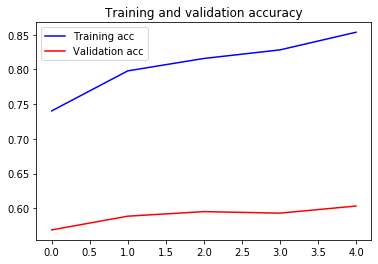

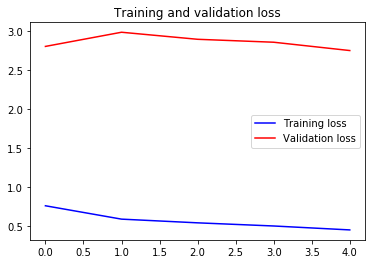

In [10]:
# Train Inception Model
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 8 classes
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# performing data argumentation by training image generator
dataAugmentation = ImageDataGenerator(rotation_range = 30, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.1, height_shift_range = 0.1)

##dataAugmentation.fit(X_train)

# train the model on the new data for a few epochs
model.fit_generator(dataAugmentation.flow(X_train, Y_train, batch_size = 32),
 validation_data = (X_valid, Y_valid), steps_per_epoch = len(X_train) // 32,
 epochs = 5)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
##for i, layer in enumerate(base_model.layers):
   ##print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
train_incept = model.fit_generator(dataAugmentation.flow(X_train, Y_train, batch_size = 32),
 validation_data = (X_valid, Y_valid), steps_per_epoch = len(X_train) // 32,
 epochs = 5)

#save the model
model.save('retrained_inception.h5')

acc = train_incept.history['acc']
val_acc = train_incept.history['val_acc']
loss = train_incept.history['loss']
val_loss = train_incept.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




Epoch 1/5
170/170 [==============================] - ETA: 36:55 - loss: 2.2335 - acc: 0.21 - ETA: 25:02 - loss: 4.5162 - acc: 0.18 - ETA: 20:53 - loss: 4.8667 - acc: 0.23 - ETA: 18:48 - loss: 5.0414 - acc: 0.24 - ETA: 17:31 - loss: 5.2552 - acc: 0.21 - ETA: 16:37 - loss: 4.7446 - acc: 0.22 - ETA: 15:58 - loss: 4.4738 - acc: 0.22 - ETA: 15:27 - loss: 4.3174 - acc: 0.20 - ETA: 15:04 - loss: 4.1857 - acc: 0.19 - ETA: 14:43 - loss: 4.0457 - acc: 0.19 - ETA: 14:24 - loss: 3.8691 - acc: 0.19 - ETA: 14:08 - loss: 3.6982 - acc: 0.20 - ETA: 13:54 - loss: 3.5498 - acc: 0.21 - ETA: 13:41 - loss: 3.4651 - acc: 0.21 - ETA: 13:29 - loss: 3.5378 - acc: 0.20 - ETA: 13:18 - loss: 3.4804 - acc: 0.20 - ETA: 13:10 - loss: 3.3902 - acc: 0.20 - ETA: 13:01 - loss: 3.3151 - acc: 0.21 - ETA: 12:53 - loss: 3.2301 - acc: 0.21 - ETA: 12:44 - loss: 3.1775 - acc: 0.20 - ETA: 12:37 - loss: 3.1275 - acc: 0.20 - ETA: 12:29 - loss: 3.0697 - acc: 0.21 - ETA: 12:11 - loss: 3.0276 - acc: 0.21 - ETA: 12:05 - loss: 2.997

170/170 [==============================] - ETA: 14:59 - loss: 1.3995 - acc: 0.37 - ETA: 15:00 - loss: 1.2145 - acc: 0.53 - ETA: 14:52 - loss: 1.1267 - acc: 0.59 - ETA: 14:32 - loss: 1.3599 - acc: 0.53 - ETA: 14:10 - loss: 1.4750 - acc: 0.50 - ETA: 13:54 - loss: 1.5045 - acc: 0.50 - ETA: 13:40 - loss: 1.4415 - acc: 0.54 - ETA: 13:29 - loss: 1.4511 - acc: 0.53 - ETA: 13:19 - loss: 1.4961 - acc: 0.50 - ETA: 13:10 - loss: 1.5152 - acc: 0.50 - ETA: 13:02 - loss: 1.5063 - acc: 0.50 - ETA: 12:54 - loss: 1.5539 - acc: 0.49 - ETA: 12:48 - loss: 1.5351 - acc: 0.50 - ETA: 12:41 - loss: 1.5159 - acc: 0.50 - ETA: 12:35 - loss: 1.4827 - acc: 0.51 - ETA: 12:30 - loss: 1.4880 - acc: 0.51 - ETA: 12:24 - loss: 1.4698 - acc: 0.52 - ETA: 12:18 - loss: 1.4668 - acc: 0.51 - ETA: 12:12 - loss: 1.4528 - acc: 0.52 - ETA: 12:06 - loss: 1.4561 - acc: 0.52 - ETA: 12:00 - loss: 1.4520 - acc: 0.52 - ETA: 11:56 - loss: 1.4498 - acc: 0.51 - ETA: 11:51 - loss: 1.4353 - acc: 0.52 - ETA: 11:45 - loss: 1.4375 - acc: 0.52

170/170 [==============================] - ETA: 13:55 - loss: 1.5690 - acc: 0.43 - ETA: 14:39 - loss: 1.4026 - acc: 0.50 - ETA: 14:46 - loss: 1.1891 - acc: 0.57 - ETA: 14:51 - loss: 1.0510 - acc: 0.61 - ETA: 14:42 - loss: 1.0565 - acc: 0.63 - ETA: 14:26 - loss: 1.1103 - acc: 0.61 - ETA: 14:15 - loss: 1.1457 - acc: 0.62 - ETA: 14:51 - loss: 1.1363 - acc: 0.62 - ETA: 14:34 - loss: 1.1334 - acc: 0.62 - ETA: 14:21 - loss: 1.1279 - acc: 0.62 - ETA: 14:06 - loss: 1.1424 - acc: 0.61 - ETA: 13:53 - loss: 1.1228 - acc: 0.62 - ETA: 13:41 - loss: 1.1084 - acc: 0.62 - ETA: 13:29 - loss: 1.1152 - acc: 0.62 - ETA: 13:19 - loss: 1.1091 - acc: 0.62 - ETA: 13:13 - loss: 1.1001 - acc: 0.62 - ETA: 13:08 - loss: 1.1059 - acc: 0.62 - ETA: 13:00 - loss: 1.1185 - acc: 0.62 - ETA: 12:54 - loss: 1.1198 - acc: 0.62 - ETA: 12:47 - loss: 1.1244 - acc: 0.62 - ETA: 12:40 - loss: 1.1337 - acc: 0.61 - ETA: 12:34 - loss: 1.1427 - acc: 0.61 - ETA: 12:29 - loss: 1.1386 - acc: 0.61 - ETA: 12:23 - loss: 1.1290 - acc: 0.61

170/170 [==============================] - ETA: 13:14 - loss: 1.0546 - acc: 0.59 - ETA: 13:12 - loss: 0.8123 - acc: 0.73 - ETA: 13:37 - loss: 0.7998 - acc: 0.72 - ETA: 13:53 - loss: 0.8987 - acc: 0.69 - ETA: 14:10 - loss: 0.8571 - acc: 0.69 - ETA: 14:05 - loss: 0.9305 - acc: 0.67 - ETA: 13:49 - loss: 0.9647 - acc: 0.65 - ETA: 13:40 - loss: 1.0261 - acc: 0.64 - ETA: 13:36 - loss: 1.0069 - acc: 0.65 - ETA: 13:29 - loss: 0.9697 - acc: 0.66 - ETA: 13:25 - loss: 0.9587 - acc: 0.67 - ETA: 13:17 - loss: 1.0295 - acc: 0.65 - ETA: 13:10 - loss: 1.0401 - acc: 0.64 - ETA: 13:02 - loss: 1.0266 - acc: 0.64 - ETA: 12:56 - loss: 1.0250 - acc: 0.64 - ETA: 12:49 - loss: 1.0330 - acc: 0.63 - ETA: 12:44 - loss: 1.0476 - acc: 0.62 - ETA: 12:37 - loss: 1.0412 - acc: 0.63 - ETA: 12:32 - loss: 1.0379 - acc: 0.63 - ETA: 12:28 - loss: 1.0280 - acc: 0.63 - ETA: 12:23 - loss: 1.0173 - acc: 0.64 - ETA: 12:17 - loss: 1.0177 - acc: 0.64 - ETA: 12:11 - loss: 1.0177 - acc: 0.64 - ETA: 12:09 - loss: 1.0410 - acc: 0.63

170/170 [==============================] - ETA: 12:37 - loss: 0.7510 - acc: 0.65 - ETA: 12:33 - loss: 0.8701 - acc: 0.65 - ETA: 12:28 - loss: 0.7477 - acc: 0.71 - ETA: 13:01 - loss: 0.7279 - acc: 0.71 - ETA: 13:14 - loss: 0.7351 - acc: 0.73 - ETA: 13:23 - loss: 0.7523 - acc: 0.72 - ETA: 13:16 - loss: 0.7663 - acc: 0.72 - ETA: 13:10 - loss: 0.8723 - acc: 0.69 - ETA: 13:06 - loss: 0.8932 - acc: 0.69 - ETA: 13:02 - loss: 0.8540 - acc: 0.70 - ETA: 12:55 - loss: 0.8580 - acc: 0.69 - ETA: 12:47 - loss: 0.8429 - acc: 0.69 - ETA: 12:42 - loss: 0.8790 - acc: 0.68 - ETA: 12:35 - loss: 0.9070 - acc: 0.67 - ETA: 12:28 - loss: 0.9234 - acc: 0.66 - ETA: 12:22 - loss: 0.9050 - acc: 0.67 - ETA: 12:18 - loss: 0.8893 - acc: 0.68 - ETA: 12:14 - loss: 0.8876 - acc: 0.68 - ETA: 12:09 - loss: 0.8831 - acc: 0.68 - ETA: 12:03 - loss: 0.9017 - acc: 0.67 - ETA: 11:58 - loss: 0.8952 - acc: 0.68 - ETA: 11:53 - loss: 0.8872 - acc: 0.68 - ETA: 11:48 - loss: 0.8801 - acc: 0.68 - ETA: 11:42 - loss: 0.8844 - acc: 0.68

170/170 [==============================] - ETA: 41:44 - loss: 1.2227 - acc: 0.56 - ETA: 30:53 - loss: 0.9784 - acc: 0.64 - ETA: 27:00 - loss: 0.8902 - acc: 0.67 - ETA: 24:53 - loss: 0.9173 - acc: 0.67 - ETA: 23:43 - loss: 0.9152 - acc: 0.66 - ETA: 22:50 - loss: 0.9472 - acc: 0.66 - ETA: 22:14 - loss: 0.9074 - acc: 0.67 - ETA: 21:45 - loss: 0.8869 - acc: 0.67 - ETA: 21:16 - loss: 0.9428 - acc: 0.66 - ETA: 20:57 - loss: 0.9252 - acc: 0.68 - ETA: 20:39 - loss: 0.9386 - acc: 0.67 - ETA: 20:24 - loss: 0.9104 - acc: 0.69 - ETA: 20:08 - loss: 0.9227 - acc: 0.68 - ETA: 19:55 - loss: 0.9130 - acc: 0.69 - ETA: 19:45 - loss: 0.8956 - acc: 0.70 - ETA: 19:32 - loss: 0.9081 - acc: 0.70 - ETA: 19:20 - loss: 0.9044 - acc: 0.70 - ETA: 19:10 - loss: 0.8956 - acc: 0.70 - ETA: 19:00 - loss: 0.8847 - acc: 0.70 - ETA: 18:49 - loss: 0.8732 - acc: 0.70 - ETA: 18:39 - loss: 0.8525 - acc: 0.70 - ETA: 18:30 - loss: 0.8476 - acc: 0.70 - ETA: 18:19 - loss: 0.8422 - acc: 0.71 - ETA: 18:09 - loss: 0.8479 - acc: 0.70

170/170 [==============================] - ETA: 23:25 - loss: 0.8225 - acc: 0.65 - ETA: 22:56 - loss: 0.7834 - acc: 0.70 - ETA: 21:43 - loss: 0.6857 - acc: 0.76 - ETA: 21:01 - loss: 0.6601 - acc: 0.77 - ETA: 20:39 - loss: 0.6807 - acc: 0.75 - ETA: 20:29 - loss: 0.6541 - acc: 0.76 - ETA: 20:14 - loss: 0.6674 - acc: 0.76 - ETA: 19:59 - loss: 0.6591 - acc: 0.76 - ETA: 19:43 - loss: 0.6680 - acc: 0.76 - ETA: 19:31 - loss: 0.6728 - acc: 0.76 - ETA: 19:23 - loss: 0.6751 - acc: 0.76 - ETA: 19:17 - loss: 0.6850 - acc: 0.76 - ETA: 19:10 - loss: 0.6521 - acc: 0.77 - ETA: 18:58 - loss: 0.6323 - acc: 0.78 - ETA: 18:50 - loss: 0.6274 - acc: 0.78 - ETA: 18:40 - loss: 0.6147 - acc: 0.79 - ETA: 18:31 - loss: 0.5920 - acc: 0.80 - ETA: 18:23 - loss: 0.5895 - acc: 0.80 - ETA: 18:15 - loss: 0.5990 - acc: 0.80 - ETA: 18:08 - loss: 0.6007 - acc: 0.80 - ETA: 18:00 - loss: 0.6014 - acc: 0.80 - ETA: 17:51 - loss: 0.6027 - acc: 0.80 - ETA: 17:42 - loss: 0.6110 - acc: 0.80 - ETA: 17:35 - loss: 0.6027 - acc: 0.80

170/170 [==============================] - ETA: 22:58 - loss: 0.6873 - acc: 0.75 - ETA: 23:09 - loss: 0.6176 - acc: 0.76 - ETA: 22:59 - loss: 0.6463 - acc: 0.78 - ETA: 22:33 - loss: 0.5646 - acc: 0.79 - ETA: 21:48 - loss: 0.5278 - acc: 0.81 - ETA: 21:19 - loss: 0.5455 - acc: 0.79 - ETA: 20:57 - loss: 0.5768 - acc: 0.77 - ETA: 20:37 - loss: 0.5541 - acc: 0.78 - ETA: 20:18 - loss: 0.5681 - acc: 0.78 - ETA: 20:01 - loss: 0.5725 - acc: 0.79 - ETA: 19:51 - loss: 0.5665 - acc: 0.79 - ETA: 19:42 - loss: 0.5515 - acc: 0.80 - ETA: 19:30 - loss: 0.5720 - acc: 0.80 - ETA: 19:19 - loss: 0.5870 - acc: 0.79 - ETA: 19:07 - loss: 0.5747 - acc: 0.80 - ETA: 18:57 - loss: 0.5959 - acc: 0.79 - ETA: 18:46 - loss: 0.5901 - acc: 0.79 - ETA: 18:36 - loss: 0.5893 - acc: 0.79 - ETA: 18:27 - loss: 0.6162 - acc: 0.78 - ETA: 18:20 - loss: 0.6157 - acc: 0.78 - ETA: 18:19 - loss: 0.6100 - acc: 0.78 - ETA: 18:12 - loss: 0.6031 - acc: 0.78 - ETA: 18:03 - loss: 0.6178 - acc: 0.78 - ETA: 17:40 - loss: 0.6290 - acc: 0.78

170/170 [==============================] - ETA: 19:15 - loss: 0.6567 - acc: 0.75 - ETA: 19:17 - loss: 0.5793 - acc: 0.76 - ETA: 20:02 - loss: 0.6384 - acc: 0.75 - ETA: 20:27 - loss: 0.6392 - acc: 0.75 - ETA: 20:05 - loss: 0.6180 - acc: 0.76 - ETA: 19:48 - loss: 0.5765 - acc: 0.77 - ETA: 19:42 - loss: 0.5546 - acc: 0.78 - ETA: 19:39 - loss: 0.5731 - acc: 0.78 - ETA: 19:35 - loss: 0.5754 - acc: 0.78 - ETA: 19:23 - loss: 0.6117 - acc: 0.77 - ETA: 19:12 - loss: 0.6029 - acc: 0.77 - ETA: 19:01 - loss: 0.6094 - acc: 0.77 - ETA: 18:51 - loss: 0.5825 - acc: 0.78 - ETA: 18:42 - loss: 0.5890 - acc: 0.79 - ETA: 18:31 - loss: 0.5846 - acc: 0.79 - ETA: 18:23 - loss: 0.5720 - acc: 0.80 - ETA: 18:13 - loss: 0.5597 - acc: 0.80 - ETA: 18:04 - loss: 0.5659 - acc: 0.80 - ETA: 17:55 - loss: 0.5574 - acc: 0.81 - ETA: 17:48 - loss: 0.5631 - acc: 0.81 - ETA: 17:40 - loss: 0.5616 - acc: 0.81 - ETA: 17:32 - loss: 0.5794 - acc: 0.80 - ETA: 17:23 - loss: 0.5708 - acc: 0.81 - ETA: 17:15 - loss: 0.5658 - acc: 0.81

170/170 [==============================] - ETA: 20:31 - loss: 0.5893 - acc: 0.81 - ETA: 20:54 - loss: 0.5566 - acc: 0.82 - ETA: 20:24 - loss: 0.5746 - acc: 0.83 - ETA: 20:33 - loss: 0.5418 - acc: 0.83 - ETA: 20:43 - loss: 0.6022 - acc: 0.82 - ETA: 20:29 - loss: 0.5549 - acc: 0.83 - ETA: 20:07 - loss: 0.5350 - acc: 0.83 - ETA: 19:54 - loss: 0.5362 - acc: 0.83 - ETA: 19:39 - loss: 0.5172 - acc: 0.83 - ETA: 19:27 - loss: 0.5674 - acc: 0.81 - ETA: 19:22 - loss: 0.5430 - acc: 0.82 - ETA: 19:10 - loss: 0.5393 - acc: 0.82 - ETA: 18:57 - loss: 0.5287 - acc: 0.82 - ETA: 18:50 - loss: 0.5271 - acc: 0.82 - ETA: 18:40 - loss: 0.5214 - acc: 0.82 - ETA: 18:37 - loss: 0.5134 - acc: 0.83 - ETA: 18:30 - loss: 0.5110 - acc: 0.82 - ETA: 18:21 - loss: 0.5129 - acc: 0.82 - ETA: 18:12 - loss: 0.5101 - acc: 0.82 - ETA: 18:02 - loss: 0.5097 - acc: 0.83 - ETA: 17:55 - loss: 0.4992 - acc: 0.83 - ETA: 17:46 - loss: 0.4975 - acc: 0.83 - ETA: 17:39 - loss: 0.5011 - acc: 0.83 - ETA: 17:33 - loss: 0.4920 - acc: 0.83

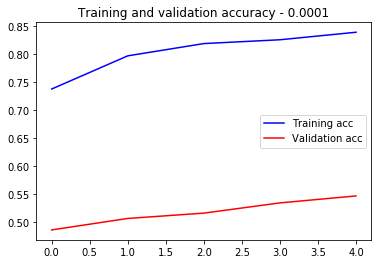

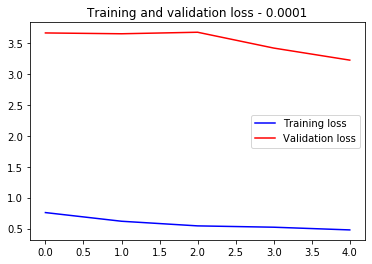

Epoch 1/5
170/170 [==============================] - ETA: 33:44 - loss: 0.4230 - acc: 0.87 - ETA: 20:54 - loss: 0.4031 - acc: 0.85 - ETA: 16:22 - loss: 0.4202 - acc: 0.85 - ETA: 14:07 - loss: 0.4320 - acc: 0.85 - ETA: 12:43 - loss: 0.4219 - acc: 0.86 - ETA: 11:48 - loss: 0.4191 - acc: 0.86 - ETA: 11:07 - loss: 0.4061 - acc: 0.86 - ETA: 10:36 - loss: 0.4193 - acc: 0.86 - ETA: 10:11 - loss: 0.3966 - acc: 0.86 - ETA: 9:51 - loss: 0.3933 - acc: 0.8656 - ETA: 9:33 - loss: 0.3862 - acc: 0.869 - ETA: 9:18 - loss: 0.3794 - acc: 0.877 - ETA: 9:05 - loss: 0.4074 - acc: 0.867 - ETA: 8:56 - loss: 0.4162 - acc: 0.866 - ETA: 8:47 - loss: 0.4130 - acc: 0.866 - ETA: 8:38 - loss: 0.4209 - acc: 0.859 - ETA: 8:29 - loss: 0.4263 - acc: 0.858 - ETA: 8:21 - loss: 0.4212 - acc: 0.862 - ETA: 8:13 - loss: 0.4235 - acc: 0.863 - ETA: 8:06 - loss: 0.4426 - acc: 0.856 - ETA: 7:59 - loss: 0.4603 - acc: 0.848 - ETA: 7:53 - loss: 0.4634 - acc: 0.849 - ETA: 7:47 - loss: 0.4729 - acc: 0.845 - ETA: 7:41 - loss: 0.4695 -

170/170 [==============================] - ETA: 9:06 - loss: 0.2001 - acc: 0.906 - ETA: 8:53 - loss: 0.1857 - acc: 0.906 - ETA: 8:29 - loss: 0.2266 - acc: 0.885 - ETA: 8:13 - loss: 0.2168 - acc: 0.890 - ETA: 8:03 - loss: 0.2706 - acc: 0.881 - ETA: 7:56 - loss: 0.3032 - acc: 0.875 - ETA: 7:50 - loss: 0.3101 - acc: 0.879 - ETA: 7:44 - loss: 0.2969 - acc: 0.882 - ETA: 7:40 - loss: 0.2890 - acc: 0.888 - ETA: 7:36 - loss: 0.2818 - acc: 0.893 - ETA: 7:31 - loss: 0.2981 - acc: 0.892 - ETA: 7:27 - loss: 0.2979 - acc: 0.893 - ETA: 7:24 - loss: 0.3009 - acc: 0.896 - ETA: 7:20 - loss: 0.3050 - acc: 0.897 - ETA: 7:16 - loss: 0.3180 - acc: 0.893 - ETA: 7:13 - loss: 0.3224 - acc: 0.890 - ETA: 7:10 - loss: 0.3220 - acc: 0.891 - ETA: 7:06 - loss: 0.3235 - acc: 0.892 - ETA: 7:03 - loss: 0.3242 - acc: 0.893 - ETA: 7:00 - loss: 0.3461 - acc: 0.882 - ETA: 6:57 - loss: 0.3368 - acc: 0.886 - ETA: 6:47 - loss: 0.3286 - acc: 0.888 - ETA: 6:45 - loss: 0.3242 - acc: 0.890 - ETA: 6:42 - loss: 0.3319 - acc: 0.887

170/170 [==============================] - ETA: 7:50 - loss: 0.2135 - acc: 0.937 - ETA: 8:28 - loss: 0.3073 - acc: 0.937 - ETA: 8:38 - loss: 0.3038 - acc: 0.927 - ETA: 8:24 - loss: 0.2967 - acc: 0.921 - ETA: 8:17 - loss: 0.3098 - acc: 0.906 - ETA: 8:09 - loss: 0.3197 - acc: 0.906 - ETA: 8:02 - loss: 0.3531 - acc: 0.892 - ETA: 7:57 - loss: 0.3418 - acc: 0.894 - ETA: 7:52 - loss: 0.3456 - acc: 0.888 - ETA: 7:47 - loss: 0.3176 - acc: 0.900 - ETA: 7:44 - loss: 0.3088 - acc: 0.900 - ETA: 7:40 - loss: 0.3140 - acc: 0.898 - ETA: 7:36 - loss: 0.3088 - acc: 0.899 - ETA: 7:32 - loss: 0.2972 - acc: 0.904 - ETA: 7:28 - loss: 0.2978 - acc: 0.904 - ETA: 7:26 - loss: 0.2996 - acc: 0.902 - ETA: 7:23 - loss: 0.3063 - acc: 0.900 - ETA: 7:19 - loss: 0.3049 - acc: 0.902 - ETA: 7:17 - loss: 0.2984 - acc: 0.906 - ETA: 7:13 - loss: 0.2911 - acc: 0.909 - ETA: 7:10 - loss: 0.2970 - acc: 0.906 - ETA: 7:07 - loss: 0.2953 - acc: 0.904 - ETA: 7:04 - loss: 0.2954 - acc: 0.907 - ETA: 7:00 - loss: 0.2928 - acc: 0.906

170/170 [==============================] - ETA: 7:37 - loss: 0.1968 - acc: 0.937 - ETA: 7:31 - loss: 0.1583 - acc: 0.953 - ETA: 7:58 - loss: 0.1746 - acc: 0.947 - ETA: 8:06 - loss: 0.1489 - acc: 0.960 - ETA: 8:01 - loss: 0.1386 - acc: 0.968 - ETA: 7:56 - loss: 0.1329 - acc: 0.968 - ETA: 7:53 - loss: 0.1545 - acc: 0.959 - ETA: 7:49 - loss: 0.1515 - acc: 0.960 - ETA: 7:44 - loss: 0.1599 - acc: 0.958 - ETA: 7:39 - loss: 0.1597 - acc: 0.956 - ETA: 7:35 - loss: 0.1600 - acc: 0.957 - ETA: 7:31 - loss: 0.1569 - acc: 0.955 - ETA: 7:29 - loss: 0.1637 - acc: 0.951 - ETA: 7:25 - loss: 0.1610 - acc: 0.953 - ETA: 7:22 - loss: 0.1654 - acc: 0.950 - ETA: 7:19 - loss: 0.1628 - acc: 0.951 - ETA: 7:16 - loss: 0.1610 - acc: 0.952 - ETA: 7:13 - loss: 0.1816 - acc: 0.947 - ETA: 7:09 - loss: 0.1757 - acc: 0.950 - ETA: 7:07 - loss: 0.1788 - acc: 0.950 - ETA: 7:06 - loss: 0.1809 - acc: 0.949 - ETA: 7:03 - loss: 0.1817 - acc: 0.948 - ETA: 7:00 - loss: 0.1850 - acc: 0.948 - ETA: 6:57 - loss: 0.1870 - acc: 0.947

170/170 [==============================] - ETA: 8:31 - loss: 0.2770 - acc: 0.937 - ETA: 8:21 - loss: 0.1901 - acc: 0.953 - ETA: 8:21 - loss: 0.1399 - acc: 0.968 - ETA: 8:53 - loss: 0.1620 - acc: 0.945 - ETA: 8:52 - loss: 0.1929 - acc: 0.925 - ETA: 8:38 - loss: 0.2056 - acc: 0.921 - ETA: 8:26 - loss: 0.1877 - acc: 0.928 - ETA: 8:17 - loss: 0.2133 - acc: 0.918 - ETA: 8:10 - loss: 0.2300 - acc: 0.920 - ETA: 8:03 - loss: 0.2270 - acc: 0.921 - ETA: 7:57 - loss: 0.2264 - acc: 0.920 - ETA: 7:52 - loss: 0.2229 - acc: 0.921 - ETA: 7:48 - loss: 0.2124 - acc: 0.925 - ETA: 7:43 - loss: 0.2130 - acc: 0.928 - ETA: 7:38 - loss: 0.2094 - acc: 0.929 - ETA: 7:33 - loss: 0.2041 - acc: 0.931 - ETA: 7:29 - loss: 0.2022 - acc: 0.932 - ETA: 7:25 - loss: 0.2082 - acc: 0.928 - ETA: 7:20 - loss: 0.2015 - acc: 0.932 - ETA: 7:17 - loss: 0.2107 - acc: 0.929 - ETA: 7:13 - loss: 0.2017 - acc: 0.933 - ETA: 7:10 - loss: 0.2094 - acc: 0.929 - ETA: 7:08 - loss: 0.2031 - acc: 0.932 - ETA: 7:04 - loss: 0.2075 - acc: 0.932

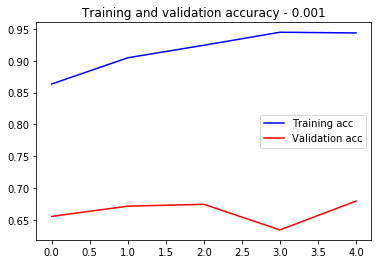

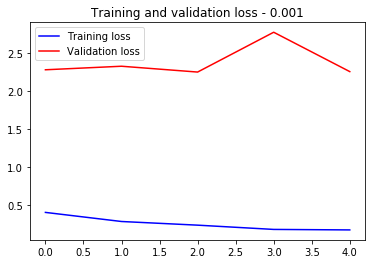

Epoch 1/5
170/170 [==============================] - ETA: 34:53 - loss: 0.0618 - acc: 0.96 - ETA: 21:30 - loss: 0.0907 - acc: 0.93 - ETA: 16:50 - loss: 0.1544 - acc: 0.91 - ETA: 14:29 - loss: 0.1664 - acc: 0.92 - ETA: 13:03 - loss: 0.2347 - acc: 0.90 - ETA: 12:06 - loss: 0.2598 - acc: 0.89 - ETA: 11:24 - loss: 0.2476 - acc: 0.90 - ETA: 10:51 - loss: 0.2498 - acc: 0.90 - ETA: 10:25 - loss: 0.2562 - acc: 0.90 - ETA: 10:06 - loss: 0.2520 - acc: 0.90 - ETA: 9:49 - loss: 0.2385 - acc: 0.9091 - ETA: 9:33 - loss: 0.2818 - acc: 0.906 - ETA: 9:20 - loss: 0.2889 - acc: 0.908 - ETA: 9:08 - loss: 0.2943 - acc: 0.906 - ETA: 8:59 - loss: 0.3091 - acc: 0.904 - ETA: 8:49 - loss: 0.3283 - acc: 0.894 - ETA: 8:40 - loss: 0.3342 - acc: 0.895 - ETA: 8:32 - loss: 0.3358 - acc: 0.894 - ETA: 8:40 - loss: 0.3323 - acc: 0.896 - ETA: 8:39 - loss: 0.3229 - acc: 0.900 - ETA: 8:31 - loss: 0.3446 - acc: 0.891 - ETA: 8:23 - loss: 0.3577 - acc: 0.889 - ETA: 8:17 - loss: 0.3592 - acc: 0.887 - ETA: 8:10 - loss: 0.3707 -

170/170 [==============================] - ETA: 9:02 - loss: 0.4856 - acc: 0.875 - ETA: 8:54 - loss: 0.2933 - acc: 0.906 - ETA: 8:33 - loss: 0.3665 - acc: 0.916 - ETA: 8:20 - loss: 0.3428 - acc: 0.906 - ETA: 8:17 - loss: 0.2903 - acc: 0.925 - ETA: 8:11 - loss: 0.2875 - acc: 0.921 - ETA: 8:04 - loss: 0.2844 - acc: 0.915 - ETA: 7:58 - loss: 0.3005 - acc: 0.914 - ETA: 7:56 - loss: 0.2831 - acc: 0.920 - ETA: 7:54 - loss: 0.2739 - acc: 0.921 - ETA: 7:49 - loss: 0.2585 - acc: 0.926 - ETA: 7:44 - loss: 0.2397 - acc: 0.932 - ETA: 7:40 - loss: 0.2349 - acc: 0.930 - ETA: 7:35 - loss: 0.2311 - acc: 0.930 - ETA: 7:31 - loss: 0.2370 - acc: 0.931 - ETA: 7:27 - loss: 0.2343 - acc: 0.931 - ETA: 7:24 - loss: 0.2244 - acc: 0.933 - ETA: 7:20 - loss: 0.2303 - acc: 0.930 - ETA: 7:17 - loss: 0.2440 - acc: 0.924 - ETA: 7:13 - loss: 0.2555 - acc: 0.925 - ETA: 7:10 - loss: 0.2616 - acc: 0.924 - ETA: 7:07 - loss: 0.2545 - acc: 0.926 - ETA: 7:04 - loss: 0.2500 - acc: 0.926 - ETA: 7:00 - loss: 0.2519 - acc: 0.925

170/170 [==============================] - ETA: 8:40 - loss: 0.3610 - acc: 0.906 - ETA: 7:26 - loss: 0.2367 - acc: 0.942 - ETA: 8:02 - loss: 0.2060 - acc: 0.952 - ETA: 8:28 - loss: 0.1859 - acc: 0.939 - ETA: 8:33 - loss: 0.1870 - acc: 0.932 - ETA: 8:30 - loss: 0.1837 - acc: 0.933 - ETA: 8:31 - loss: 0.2156 - acc: 0.924 - ETA: 8:25 - loss: 0.2208 - acc: 0.922 - ETA: 8:19 - loss: 0.2155 - acc: 0.920 - ETA: 8:14 - loss: 0.2115 - acc: 0.918 - ETA: 8:13 - loss: 0.2177 - acc: 0.914 - ETA: 8:08 - loss: 0.2032 - acc: 0.922 - ETA: 8:02 - loss: 0.1970 - acc: 0.923 - ETA: 7:56 - loss: 0.2001 - acc: 0.922 - ETA: 7:51 - loss: 0.2053 - acc: 0.920 - ETA: 7:46 - loss: 0.2176 - acc: 0.920 - ETA: 7:41 - loss: 0.2117 - acc: 0.924 - ETA: 7:37 - loss: 0.2314 - acc: 0.920 - ETA: 7:32 - loss: 0.2338 - acc: 0.919 - ETA: 7:28 - loss: 0.2317 - acc: 0.920 - ETA: 7:24 - loss: 0.2269 - acc: 0.921 - ETA: 7:20 - loss: 0.2194 - acc: 0.923 - ETA: 7:16 - loss: 0.2274 - acc: 0.922 - ETA: 7:19 - loss: 0.2239 - acc: 0.923

170/170 [==============================] - ETA: 8:03 - loss: 0.1194 - acc: 0.968 - ETA: 7:56 - loss: 0.1245 - acc: 0.953 - ETA: 8:16 - loss: 0.1087 - acc: 0.958 - ETA: 8:21 - loss: 0.1739 - acc: 0.945 - ETA: 8:13 - loss: 0.1708 - acc: 0.950 - ETA: 8:03 - loss: 0.1617 - acc: 0.947 - ETA: 7:58 - loss: 0.1680 - acc: 0.937 - ETA: 7:53 - loss: 0.1557 - acc: 0.941 - ETA: 7:48 - loss: 0.1728 - acc: 0.944 - ETA: 7:48 - loss: 0.1626 - acc: 0.946 - ETA: 7:44 - loss: 0.1642 - acc: 0.946 - ETA: 7:50 - loss: 0.1543 - acc: 0.950 - ETA: 7:49 - loss: 0.1457 - acc: 0.954 - ETA: 7:45 - loss: 0.1433 - acc: 0.953 - ETA: 7:44 - loss: 0.1407 - acc: 0.952 - ETA: 7:41 - loss: 0.1359 - acc: 0.955 - ETA: 7:42 - loss: 0.1320 - acc: 0.957 - ETA: 7:38 - loss: 0.1377 - acc: 0.953 - ETA: 7:40 - loss: 0.1437 - acc: 0.952 - ETA: 7:43 - loss: 0.1457 - acc: 0.951 - ETA: 7:40 - loss: 0.1414 - acc: 0.952 - ETA: 7:44 - loss: 0.1407 - acc: 0.953 - ETA: 7:40 - loss: 0.1430 - acc: 0.951 - ETA: 7:35 - loss: 0.1464 - acc: 0.947

170/170 [==============================] - ETA: 7:44 - loss: 0.2845 - acc: 0.937 - ETA: 7:44 - loss: 0.1875 - acc: 0.937 - ETA: 7:39 - loss: 0.1571 - acc: 0.947 - ETA: 7:55 - loss: 0.1269 - acc: 0.960 - ETA: 8:02 - loss: 0.1087 - acc: 0.962 - ETA: 7:56 - loss: 0.1326 - acc: 0.947 - ETA: 7:56 - loss: 0.1205 - acc: 0.950 - ETA: 7:56 - loss: 0.1256 - acc: 0.949 - ETA: 7:59 - loss: 0.1136 - acc: 0.954 - ETA: 8:07 - loss: 0.1133 - acc: 0.953 - ETA: 8:05 - loss: 0.1034 - acc: 0.957 - ETA: 8:02 - loss: 0.0981 - acc: 0.958 - ETA: 7:58 - loss: 0.0995 - acc: 0.956 - ETA: 7:53 - loss: 0.1175 - acc: 0.955 - ETA: 7:51 - loss: 0.1244 - acc: 0.954 - ETA: 7:48 - loss: 0.1239 - acc: 0.953 - ETA: 7:45 - loss: 0.1280 - acc: 0.952 - ETA: 7:42 - loss: 0.1313 - acc: 0.951 - ETA: 7:38 - loss: 0.1303 - acc: 0.952 - ETA: 7:34 - loss: 0.1245 - acc: 0.954 - ETA: 7:31 - loss: 0.1243 - acc: 0.953 - ETA: 7:28 - loss: 0.1267 - acc: 0.951 - ETA: 7:25 - loss: 0.1219 - acc: 0.953 - ETA: 7:21 - loss: 0.1184 - acc: 0.955

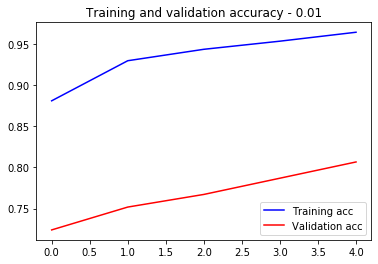

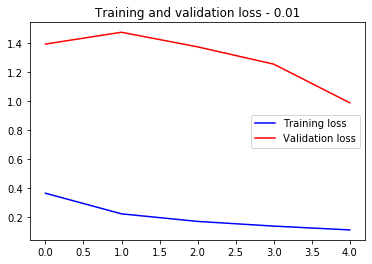

Epoch 1/5
170/170 [==============================] - ETA: 42:03 - loss: 0.0360 - acc: 0.96 - ETA: 27:53 - loss: 0.1482 - acc: 0.93 - ETA: 21:27 - loss: 0.1201 - acc: 0.95 - ETA: 18:27 - loss: 0.1401 - acc: 0.95 - ETA: 16:35 - loss: 0.1916 - acc: 0.95 - ETA: 15:29 - loss: 0.1971 - acc: 0.94 - ETA: 14:19 - loss: 0.2102 - acc: 0.94 - ETA: 13:26 - loss: 0.2229 - acc: 0.94 - ETA: 12:43 - loss: 0.2195 - acc: 0.94 - ETA: 12:07 - loss: 0.2202 - acc: 0.94 - ETA: 11:37 - loss: 0.2088 - acc: 0.94 - ETA: 11:12 - loss: 0.2387 - acc: 0.93 - ETA: 10:53 - loss: 0.2709 - acc: 0.92 - ETA: 10:34 - loss: 0.2845 - acc: 0.92 - ETA: 10:17 - loss: 0.2798 - acc: 0.92 - ETA: 10:03 - loss: 0.2807 - acc: 0.92 - ETA: 9:49 - loss: 0.2898 - acc: 0.9191 - ETA: 9:38 - loss: 0.3063 - acc: 0.911 - ETA: 9:27 - loss: 0.3129 - acc: 0.911 - ETA: 9:16 - loss: 0.3268 - acc: 0.903 - ETA: 9:06 - loss: 0.3342 - acc: 0.900 - ETA: 8:56 - loss: 0.3524 - acc: 0.889 - ETA: 8:47 - loss: 0.3619 - acc: 0.889 - ETA: 8:39 - loss: 0.3719 -

170/170 [==============================] - ETA: 9:18 - loss: 0.3691 - acc: 0.875 - ETA: 9:05 - loss: 0.3699 - acc: 0.890 - ETA: 8:46 - loss: 0.4174 - acc: 0.895 - ETA: 8:36 - loss: 0.3878 - acc: 0.906 - ETA: 8:27 - loss: 0.4352 - acc: 0.881 - ETA: 8:20 - loss: 0.4923 - acc: 0.869 - ETA: 8:15 - loss: 0.5206 - acc: 0.852 - ETA: 8:10 - loss: 0.4597 - acc: 0.871 - ETA: 8:04 - loss: 0.4616 - acc: 0.878 - ETA: 7:59 - loss: 0.5025 - acc: 0.865 - ETA: 7:55 - loss: 0.5112 - acc: 0.863 - ETA: 7:51 - loss: 0.5058 - acc: 0.859 - ETA: 7:46 - loss: 0.4993 - acc: 0.863 - ETA: 7:41 - loss: 0.5102 - acc: 0.857 - ETA: 7:37 - loss: 0.4904 - acc: 0.860 - ETA: 7:33 - loss: 0.4798 - acc: 0.861 - ETA: 7:30 - loss: 0.4871 - acc: 0.858 - ETA: 7:26 - loss: 0.4809 - acc: 0.857 - ETA: 7:22 - loss: 0.4869 - acc: 0.858 - ETA: 7:19 - loss: 0.4892 - acc: 0.854 - ETA: 7:16 - loss: 0.4880 - acc: 0.851 - ETA: 7:13 - loss: 0.4870 - acc: 0.850 - ETA: 7:10 - loss: 0.4718 - acc: 0.856 - ETA: 7:06 - loss: 0.4615 - acc: 0.858

170/170 [==============================] - ETA: 7:39 - loss: 0.1747 - acc: 0.937 - ETA: 8:19 - loss: 0.1193 - acc: 0.968 - ETA: 8:28 - loss: 0.1899 - acc: 0.927 - ETA: 8:16 - loss: 0.1652 - acc: 0.945 - ETA: 8:07 - loss: 0.2044 - acc: 0.937 - ETA: 8:01 - loss: 0.1901 - acc: 0.942 - ETA: 7:55 - loss: 0.1823 - acc: 0.946 - ETA: 7:50 - loss: 0.1771 - acc: 0.949 - ETA: 7:45 - loss: 0.1708 - acc: 0.951 - ETA: 7:43 - loss: 0.2147 - acc: 0.943 - ETA: 7:39 - loss: 0.2181 - acc: 0.943 - ETA: 7:35 - loss: 0.2137 - acc: 0.945 - ETA: 7:32 - loss: 0.2220 - acc: 0.942 - ETA: 7:28 - loss: 0.2186 - acc: 0.939 - ETA: 7:26 - loss: 0.2276 - acc: 0.937 - ETA: 7:24 - loss: 0.2232 - acc: 0.939 - ETA: 7:22 - loss: 0.2565 - acc: 0.933 - ETA: 7:19 - loss: 0.2660 - acc: 0.925 - ETA: 7:16 - loss: 0.2727 - acc: 0.922 - ETA: 7:13 - loss: 0.2745 - acc: 0.920 - ETA: 7:10 - loss: 0.2719 - acc: 0.921 - ETA: 7:07 - loss: 0.2647 - acc: 0.921 - ETA: 7:04 - loss: 0.2607 - acc: 0.922 - ETA: 7:00 - loss: 0.2591 - acc: 0.923

170/170 [==============================] - ETA: 7:49 - loss: 0.1336 - acc: 0.968 - ETA: 7:51 - loss: 0.2550 - acc: 0.890 - ETA: 8:13 - loss: 0.2400 - acc: 0.906 - ETA: 8:18 - loss: 0.2314 - acc: 0.914 - ETA: 8:09 - loss: 0.2100 - acc: 0.925 - ETA: 8:02 - loss: 0.2169 - acc: 0.921 - ETA: 7:57 - loss: 0.2165 - acc: 0.924 - ETA: 7:52 - loss: 0.2027 - acc: 0.929 - ETA: 7:47 - loss: 0.1929 - acc: 0.934 - ETA: 7:43 - loss: 0.1976 - acc: 0.931 - ETA: 7:39 - loss: 0.2160 - acc: 0.926 - ETA: 7:35 - loss: 0.2117 - acc: 0.929 - ETA: 7:32 - loss: 0.2045 - acc: 0.932 - ETA: 7:29 - loss: 0.1957 - acc: 0.935 - ETA: 7:25 - loss: 0.2111 - acc: 0.929 - ETA: 7:22 - loss: 0.2002 - acc: 0.933 - ETA: 7:19 - loss: 0.2012 - acc: 0.932 - ETA: 7:15 - loss: 0.2154 - acc: 0.930 - ETA: 7:12 - loss: 0.2138 - acc: 0.932 - ETA: 7:09 - loss: 0.2052 - acc: 0.934 - ETA: 7:06 - loss: 0.2069 - acc: 0.934 - ETA: 7:04 - loss: 0.2038 - acc: 0.936 - ETA: 7:01 - loss: 0.2086 - acc: 0.937 - ETA: 6:58 - loss: 0.2085 - acc: 0.938

170/170 [==============================] - ETA: 8:05 - loss: 0.5286 - acc: 0.812 - ETA: 7:51 - loss: 0.3132 - acc: 0.890 - ETA: 7:44 - loss: 0.2375 - acc: 0.916 - ETA: 8:00 - loss: 0.2230 - acc: 0.921 - ETA: 8:10 - loss: 0.2591 - acc: 0.912 - ETA: 8:04 - loss: 0.2620 - acc: 0.911 - ETA: 7:58 - loss: 0.2558 - acc: 0.910 - ETA: 7:52 - loss: 0.2475 - acc: 0.918 - ETA: 7:47 - loss: 0.2459 - acc: 0.920 - ETA: 7:43 - loss: 0.2504 - acc: 0.925 - ETA: 7:39 - loss: 0.2640 - acc: 0.920 - ETA: 7:35 - loss: 0.2510 - acc: 0.924 - ETA: 7:32 - loss: 0.2378 - acc: 0.930 - ETA: 7:29 - loss: 0.2340 - acc: 0.930 - ETA: 7:26 - loss: 0.2276 - acc: 0.933 - ETA: 7:23 - loss: 0.2276 - acc: 0.933 - ETA: 7:20 - loss: 0.2183 - acc: 0.935 - ETA: 7:16 - loss: 0.2149 - acc: 0.937 - ETA: 7:13 - loss: 0.2144 - acc: 0.935 - ETA: 7:10 - loss: 0.2103 - acc: 0.935 - ETA: 7:07 - loss: 0.2035 - acc: 0.937 - ETA: 7:04 - loss: 0.2014 - acc: 0.938 - ETA: 7:01 - loss: 0.1967 - acc: 0.940 - ETA: 6:58 - loss: 0.2013 - acc: 0.936

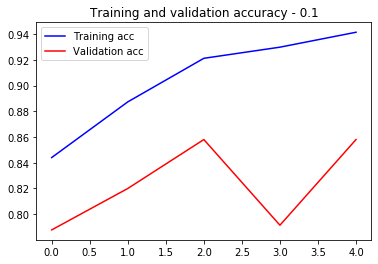

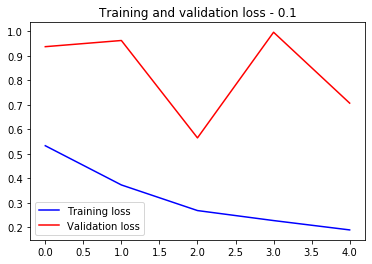

Epoch 1/5
170/170 [==============================] - ETA: 20:32 - loss: 2.1172 - acc: 0.25 - ETA: 15:00 - loss: 2.0968 - acc: 0.29 - ETA: 13:03 - loss: 2.1776 - acc: 0.25 - ETA: 12:01 - loss: 2.1235 - acc: 0.29 - ETA: 11:18 - loss: 2.0841 - acc: 0.26 - ETA: 10:49 - loss: 2.1704 - acc: 0.23 - ETA: 10:28 - loss: 2.1299 - acc: 0.25 - ETA: 10:10 - loss: 2.1066 - acc: 0.25 - ETA: 9:56 - loss: 2.0602 - acc: 0.2674 - ETA: 9:45 - loss: 2.0389 - acc: 0.262 - ETA: 9:35 - loss: 2.0328 - acc: 0.267 - ETA: 9:26 - loss: 1.9953 - acc: 0.289 - ETA: 9:19 - loss: 1.9569 - acc: 0.305 - ETA: 9:11 - loss: 1.9255 - acc: 0.319 - ETA: 9:04 - loss: 1.9188 - acc: 0.314 - ETA: 8:58 - loss: 1.8989 - acc: 0.322 - ETA: 8:52 - loss: 1.8703 - acc: 0.332 - ETA: 8:46 - loss: 1.8638 - acc: 0.328 - ETA: 8:41 - loss: 1.8497 - acc: 0.333 - ETA: 8:35 - loss: 1.8387 - acc: 0.337 - ETA: 8:30 - loss: 1.8203 - acc: 0.342 - ETA: 8:25 - loss: 1.8012 - acc: 0.349 - ETA: 8:20 - loss: 1.7739 - acc: 0.361 - ETA: 8:16 - loss: 1.7568 -

170/170 [==============================] - ETA: 9:22 - loss: 0.9105 - acc: 0.562 - ETA: 9:21 - loss: 1.0311 - acc: 0.562 - ETA: 9:22 - loss: 0.9856 - acc: 0.635 - ETA: 9:18 - loss: 0.9390 - acc: 0.648 - ETA: 9:15 - loss: 0.9207 - acc: 0.656 - ETA: 9:11 - loss: 0.9120 - acc: 0.651 - ETA: 9:04 - loss: 0.8738 - acc: 0.674 - ETA: 8:57 - loss: 0.8977 - acc: 0.664 - ETA: 8:52 - loss: 0.8790 - acc: 0.670 - ETA: 8:47 - loss: 0.8759 - acc: 0.681 - ETA: 8:42 - loss: 0.8635 - acc: 0.690 - ETA: 8:38 - loss: 0.8377 - acc: 0.705 - ETA: 8:33 - loss: 0.8219 - acc: 0.709 - ETA: 8:29 - loss: 0.8171 - acc: 0.709 - ETA: 8:25 - loss: 0.8030 - acc: 0.716 - ETA: 8:23 - loss: 0.7983 - acc: 0.720 - ETA: 8:19 - loss: 0.7994 - acc: 0.720 - ETA: 8:15 - loss: 0.7885 - acc: 0.722 - ETA: 8:12 - loss: 0.7768 - acc: 0.728 - ETA: 8:08 - loss: 0.7750 - acc: 0.726 - ETA: 8:04 - loss: 0.7704 - acc: 0.729 - ETA: 8:01 - loss: 0.7765 - acc: 0.727 - ETA: 7:57 - loss: 0.7857 - acc: 0.726 - ETA: 7:54 - loss: 0.7915 - acc: 0.729

170/170 [==============================] - ETA: 8:56 - loss: 0.7793 - acc: 0.781 - ETA: 9:05 - loss: 0.7872 - acc: 0.765 - ETA: 9:05 - loss: 0.7864 - acc: 0.770 - ETA: 9:06 - loss: 0.7054 - acc: 0.804 - ETA: 9:08 - loss: 0.6826 - acc: 0.793 - ETA: 9:08 - loss: 0.6512 - acc: 0.791 - ETA: 9:07 - loss: 0.6400 - acc: 0.794 - ETA: 9:03 - loss: 0.6280 - acc: 0.800 - ETA: 8:57 - loss: 0.6315 - acc: 0.805 - ETA: 8:51 - loss: 0.6193 - acc: 0.812 - ETA: 8:46 - loss: 0.6354 - acc: 0.804 - ETA: 8:41 - loss: 0.6138 - acc: 0.815 - ETA: 8:36 - loss: 0.6097 - acc: 0.810 - ETA: 8:32 - loss: 0.6035 - acc: 0.812 - ETA: 8:28 - loss: 0.5966 - acc: 0.812 - ETA: 8:24 - loss: 0.5906 - acc: 0.814 - ETA: 8:22 - loss: 0.5898 - acc: 0.816 - ETA: 8:19 - loss: 0.5959 - acc: 0.819 - ETA: 8:16 - loss: 0.5775 - acc: 0.825 - ETA: 8:12 - loss: 0.5651 - acc: 0.826 - ETA: 8:09 - loss: 0.5621 - acc: 0.825 - ETA: 8:06 - loss: 0.5555 - acc: 0.829 - ETA: 8:03 - loss: 0.5549 - acc: 0.831 - ETA: 8:00 - loss: 0.5510 - acc: 0.833

170/170 [==============================] - ETA: 8:48 - loss: 0.4062 - acc: 0.875 - ETA: 8:47 - loss: 0.4666 - acc: 0.859 - ETA: 8:55 - loss: 0.4058 - acc: 0.885 - ETA: 8:57 - loss: 0.3878 - acc: 0.882 - ETA: 9:00 - loss: 0.3603 - acc: 0.900 - ETA: 8:58 - loss: 0.3782 - acc: 0.890 - ETA: 8:57 - loss: 0.4199 - acc: 0.870 - ETA: 8:56 - loss: 0.4210 - acc: 0.867 - ETA: 8:54 - loss: 0.4115 - acc: 0.868 - ETA: 8:49 - loss: 0.3986 - acc: 0.868 - ETA: 8:45 - loss: 0.4055 - acc: 0.860 - ETA: 8:40 - loss: 0.3923 - acc: 0.869 - ETA: 8:38 - loss: 0.4083 - acc: 0.867 - ETA: 8:33 - loss: 0.4002 - acc: 0.872 - ETA: 8:29 - loss: 0.4045 - acc: 0.868 - ETA: 8:25 - loss: 0.4159 - acc: 0.863 - ETA: 8:21 - loss: 0.4227 - acc: 0.860 - ETA: 8:18 - loss: 0.4181 - acc: 0.861 - ETA: 8:14 - loss: 0.4189 - acc: 0.860 - ETA: 8:11 - loss: 0.4205 - acc: 0.859 - ETA: 8:07 - loss: 0.4143 - acc: 0.863 - ETA: 8:04 - loss: 0.4254 - acc: 0.860 - ETA: 8:00 - loss: 0.4264 - acc: 0.858 - ETA: 7:57 - loss: 0.4282 - acc: 0.858

170/170 [==============================] - ETA: 8:48 - loss: 0.3759 - acc: 0.875 - ETA: 8:47 - loss: 0.3559 - acc: 0.875 - ETA: 8:44 - loss: 0.4016 - acc: 0.864 - ETA: 8:54 - loss: 0.3674 - acc: 0.867 - ETA: 8:58 - loss: 0.3555 - acc: 0.868 - ETA: 8:59 - loss: 0.3444 - acc: 0.875 - ETA: 8:57 - loss: 0.3343 - acc: 0.875 - ETA: 8:57 - loss: 0.3172 - acc: 0.886 - ETA: 8:54 - loss: 0.3035 - acc: 0.892 - ETA: 8:53 - loss: 0.3040 - acc: 0.896 - ETA: 8:48 - loss: 0.3156 - acc: 0.883 - ETA: 8:44 - loss: 0.3348 - acc: 0.877 - ETA: 8:40 - loss: 0.3559 - acc: 0.867 - ETA: 8:36 - loss: 0.3644 - acc: 0.863 - ETA: 8:32 - loss: 0.3614 - acc: 0.862 - ETA: 8:28 - loss: 0.3570 - acc: 0.865 - ETA: 8:24 - loss: 0.3512 - acc: 0.869 - ETA: 8:20 - loss: 0.3450 - acc: 0.873 - ETA: 8:16 - loss: 0.3442 - acc: 0.875 - ETA: 8:12 - loss: 0.3424 - acc: 0.876 - ETA: 8:08 - loss: 0.3359 - acc: 0.879 - ETA: 8:05 - loss: 0.3276 - acc: 0.882 - ETA: 8:02 - loss: 0.3402 - acc: 0.877 - ETA: 7:58 - loss: 0.3371 - acc: 0.877

170/170 [==============================] - ETA: 17:26 - loss: 0.4026 - acc: 0.81 - ETA: 13:19 - loss: 0.3276 - acc: 0.87 - ETA: 11:54 - loss: 0.3330 - acc: 0.88 - ETA: 11:10 - loss: 0.2821 - acc: 0.91 - ETA: 10:41 - loss: 0.2725 - acc: 0.91 - ETA: 10:18 - loss: 0.2743 - acc: 0.90 - ETA: 10:00 - loss: 0.2585 - acc: 0.91 - ETA: 9:45 - loss: 0.2918 - acc: 0.8945 - ETA: 9:34 - loss: 0.3375 - acc: 0.888 - ETA: 9:24 - loss: 0.3313 - acc: 0.893 - ETA: 9:15 - loss: 0.3170 - acc: 0.897 - ETA: 9:07 - loss: 0.3125 - acc: 0.898 - ETA: 9:00 - loss: 0.3237 - acc: 0.894 - ETA: 8:54 - loss: 0.3312 - acc: 0.895 - ETA: 8:48 - loss: 0.3328 - acc: 0.895 - ETA: 8:43 - loss: 0.3294 - acc: 0.896 - ETA: 8:37 - loss: 0.3277 - acc: 0.897 - ETA: 8:32 - loss: 0.3271 - acc: 0.895 - ETA: 8:28 - loss: 0.3249 - acc: 0.893 - ETA: 8:23 - loss: 0.3258 - acc: 0.892 - ETA: 8:20 - loss: 0.3210 - acc: 0.894 - ETA: 8:15 - loss: 0.3268 - acc: 0.890 - ETA: 8:04 - loss: 0.3227 - acc: 0.890 - ETA: 8:00 - loss: 0.3286 - acc: 0.88

170/170 [==============================] - ETA: 9:20 - loss: 0.1939 - acc: 0.937 - ETA: 9:17 - loss: 0.1552 - acc: 0.968 - ETA: 9:22 - loss: 0.2301 - acc: 0.927 - ETA: 9:19 - loss: 0.2322 - acc: 0.929 - ETA: 9:15 - loss: 0.2695 - acc: 0.918 - ETA: 9:10 - loss: 0.2512 - acc: 0.921 - ETA: 9:07 - loss: 0.2466 - acc: 0.928 - ETA: 9:03 - loss: 0.2394 - acc: 0.925 - ETA: 8:57 - loss: 0.2342 - acc: 0.927 - ETA: 8:51 - loss: 0.2453 - acc: 0.918 - ETA: 8:46 - loss: 0.2442 - acc: 0.920 - ETA: 8:41 - loss: 0.2496 - acc: 0.914 - ETA: 8:36 - loss: 0.2541 - acc: 0.911 - ETA: 8:31 - loss: 0.2509 - acc: 0.912 - ETA: 8:27 - loss: 0.2634 - acc: 0.908 - ETA: 8:23 - loss: 0.2709 - acc: 0.906 - ETA: 8:19 - loss: 0.2778 - acc: 0.902 - ETA: 8:15 - loss: 0.2748 - acc: 0.902 - ETA: 8:11 - loss: 0.2750 - acc: 0.901 - ETA: 8:07 - loss: 0.2668 - acc: 0.906 - ETA: 8:03 - loss: 0.2669 - acc: 0.906 - ETA: 8:00 - loss: 0.2665 - acc: 0.909 - ETA: 7:56 - loss: 0.2695 - acc: 0.906 - ETA: 7:52 - loss: 0.2721 - acc: 0.906

170/170 [==============================] - ETA: 8:49 - loss: 0.2993 - acc: 0.906 - ETA: 9:27 - loss: 0.3700 - acc: 0.875 - ETA: 9:33 - loss: 0.3045 - acc: 0.895 - ETA: 9:28 - loss: 0.2579 - acc: 0.914 - ETA: 9:21 - loss: 0.2338 - acc: 0.925 - ETA: 9:14 - loss: 0.2365 - acc: 0.921 - ETA: 9:09 - loss: 0.2349 - acc: 0.924 - ETA: 9:03 - loss: 0.2578 - acc: 0.910 - ETA: 8:56 - loss: 0.2570 - acc: 0.913 - ETA: 8:50 - loss: 0.2633 - acc: 0.912 - ETA: 8:45 - loss: 0.2780 - acc: 0.909 - ETA: 8:39 - loss: 0.2779 - acc: 0.908 - ETA: 8:34 - loss: 0.2795 - acc: 0.903 - ETA: 8:30 - loss: 0.2887 - acc: 0.904 - ETA: 8:25 - loss: 0.2943 - acc: 0.902 - ETA: 8:21 - loss: 0.2944 - acc: 0.898 - ETA: 8:17 - loss: 0.2984 - acc: 0.893 - ETA: 8:13 - loss: 0.2959 - acc: 0.895 - ETA: 8:09 - loss: 0.2971 - acc: 0.896 - ETA: 8:05 - loss: 0.3066 - acc: 0.893 - ETA: 8:01 - loss: 0.3033 - acc: 0.895 - ETA: 7:57 - loss: 0.2980 - acc: 0.897 - ETA: 7:54 - loss: 0.2999 - acc: 0.896 - ETA: 7:50 - loss: 0.2940 - acc: 0.899

170/170 [==============================] - ETA: 8:41 - loss: 0.2015 - acc: 0.875 - ETA: 8:34 - loss: 0.2944 - acc: 0.859 - ETA: 8:44 - loss: 0.3613 - acc: 0.843 - ETA: 8:47 - loss: 0.3130 - acc: 0.859 - ETA: 8:48 - loss: 0.2749 - acc: 0.887 - ETA: 8:52 - loss: 0.2676 - acc: 0.895 - ETA: 8:50 - loss: 0.2709 - acc: 0.897 - ETA: 8:47 - loss: 0.2580 - acc: 0.902 - ETA: 8:45 - loss: 0.2791 - acc: 0.895 - ETA: 8:41 - loss: 0.2804 - acc: 0.896 - ETA: 8:38 - loss: 0.2702 - acc: 0.897 - ETA: 8:34 - loss: 0.2666 - acc: 0.898 - ETA: 8:30 - loss: 0.2762 - acc: 0.891 - ETA: 8:25 - loss: 0.2719 - acc: 0.897 - ETA: 8:23 - loss: 0.2782 - acc: 0.891 - ETA: 8:18 - loss: 0.2734 - acc: 0.892 - ETA: 8:15 - loss: 0.2759 - acc: 0.891 - ETA: 8:11 - loss: 0.2731 - acc: 0.894 - ETA: 8:08 - loss: 0.2713 - acc: 0.893 - ETA: 8:04 - loss: 0.2742 - acc: 0.890 - ETA: 8:00 - loss: 0.2720 - acc: 0.891 - ETA: 7:57 - loss: 0.2717 - acc: 0.892 - ETA: 7:53 - loss: 0.2752 - acc: 0.888 - ETA: 7:49 - loss: 0.2762 - acc: 0.888

170/170 [==============================] - ETA: 8:34 - loss: 0.3462 - acc: 0.875 - ETA: 8:31 - loss: 0.3117 - acc: 0.875 - ETA: 8:29 - loss: 0.2782 - acc: 0.895 - ETA: 8:38 - loss: 0.2898 - acc: 0.898 - ETA: 8:40 - loss: 0.2610 - acc: 0.906 - ETA: 8:41 - loss: 0.2522 - acc: 0.916 - ETA: 8:42 - loss: 0.2383 - acc: 0.919 - ETA: 8:41 - loss: 0.2243 - acc: 0.925 - ETA: 8:39 - loss: 0.2289 - acc: 0.927 - ETA: 8:36 - loss: 0.2217 - acc: 0.928 - ETA: 8:32 - loss: 0.2212 - acc: 0.929 - ETA: 8:28 - loss: 0.2270 - acc: 0.927 - ETA: 8:24 - loss: 0.2285 - acc: 0.925 - ETA: 8:20 - loss: 0.2362 - acc: 0.921 - ETA: 8:16 - loss: 0.2384 - acc: 0.920 - ETA: 8:13 - loss: 0.2363 - acc: 0.923 - ETA: 8:09 - loss: 0.2506 - acc: 0.917 - ETA: 8:07 - loss: 0.2621 - acc: 0.913 - ETA: 8:04 - loss: 0.2667 - acc: 0.911 - ETA: 8:00 - loss: 0.2682 - acc: 0.912 - ETA: 7:56 - loss: 0.2710 - acc: 0.910 - ETA: 7:53 - loss: 0.2663 - acc: 0.913 - ETA: 7:49 - loss: 0.2727 - acc: 0.911 - ETA: 7:46 - loss: 0.2753 - acc: 0.910

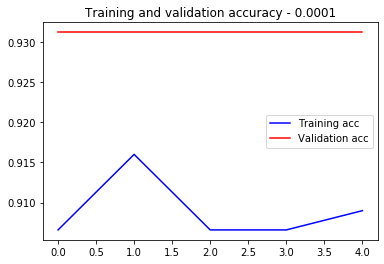

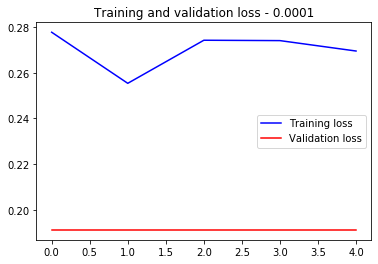

Epoch 1/5
170/170 [==============================] - ETA: 18:46 - loss: 0.3111 - acc: 0.90 - ETA: 14:03 - loss: 0.2347 - acc: 0.93 - ETA: 12:23 - loss: 0.3123 - acc: 0.89 - ETA: 11:29 - loss: 0.2819 - acc: 0.90 - ETA: 10:54 - loss: 0.2639 - acc: 0.90 - ETA: 10:29 - loss: 0.2788 - acc: 0.90 - ETA: 10:15 - loss: 0.2606 - acc: 0.90 - ETA: 10:02 - loss: 0.2656 - acc: 0.91 - ETA: 9:57 - loss: 0.2574 - acc: 0.9132 - ETA: 9:55 - loss: 0.2617 - acc: 0.915 - ETA: 9:46 - loss: 0.2641 - acc: 0.909 - ETA: 9:35 - loss: 0.2588 - acc: 0.914 - ETA: 9:26 - loss: 0.2683 - acc: 0.913 - ETA: 9:17 - loss: 0.2548 - acc: 0.917 - ETA: 9:09 - loss: 0.2508 - acc: 0.918 - ETA: 9:02 - loss: 0.2548 - acc: 0.916 - ETA: 8:55 - loss: 0.2624 - acc: 0.915 - ETA: 8:49 - loss: 0.2550 - acc: 0.918 - ETA: 8:43 - loss: 0.2653 - acc: 0.914 - ETA: 8:38 - loss: 0.2610 - acc: 0.915 - ETA: 8:32 - loss: 0.2734 - acc: 0.909 - ETA: 8:27 - loss: 0.2758 - acc: 0.909 - ETA: 8:30 - loss: 0.2799 - acc: 0.909 - ETA: 8:25 - loss: 0.2757 -

170/170 [==============================] - ETA: 9:03 - loss: 0.1308 - acc: 1.000 - ETA: 9:09 - loss: 0.2581 - acc: 0.921 - ETA: 9:08 - loss: 0.2673 - acc: 0.927 - ETA: 9:06 - loss: 0.2336 - acc: 0.937 - ETA: 9:02 - loss: 0.2153 - acc: 0.943 - ETA: 9:00 - loss: 0.2253 - acc: 0.937 - ETA: 8:56 - loss: 0.2155 - acc: 0.937 - ETA: 8:50 - loss: 0.2196 - acc: 0.937 - ETA: 8:45 - loss: 0.2368 - acc: 0.934 - ETA: 8:40 - loss: 0.2579 - acc: 0.925 - ETA: 8:37 - loss: 0.2571 - acc: 0.923 - ETA: 8:33 - loss: 0.2407 - acc: 0.929 - ETA: 8:28 - loss: 0.2354 - acc: 0.930 - ETA: 8:24 - loss: 0.2486 - acc: 0.926 - ETA: 8:09 - loss: 0.2626 - acc: 0.923 - ETA: 8:07 - loss: 0.2776 - acc: 0.918 - ETA: 8:04 - loss: 0.2769 - acc: 0.915 - ETA: 8:01 - loss: 0.2717 - acc: 0.916 - ETA: 7:58 - loss: 0.2780 - acc: 0.914 - ETA: 7:55 - loss: 0.2745 - acc: 0.917 - ETA: 7:53 - loss: 0.2820 - acc: 0.912 - ETA: 7:50 - loss: 0.2891 - acc: 0.909 - ETA: 7:47 - loss: 0.2906 - acc: 0.907 - ETA: 7:44 - loss: 0.2967 - acc: 0.904

170/170 [==============================] - ETA: 8:45 - loss: 0.4833 - acc: 0.875 - ETA: 9:03 - loss: 0.3942 - acc: 0.875 - ETA: 9:06 - loss: 0.3777 - acc: 0.875 - ETA: 9:05 - loss: 0.3330 - acc: 0.882 - ETA: 9:02 - loss: 0.2954 - acc: 0.900 - ETA: 9:04 - loss: 0.2993 - acc: 0.895 - ETA: 9:01 - loss: 0.3129 - acc: 0.892 - ETA: 9:00 - loss: 0.3060 - acc: 0.898 - ETA: 8:57 - loss: 0.3145 - acc: 0.895 - ETA: 8:52 - loss: 0.3136 - acc: 0.893 - ETA: 8:50 - loss: 0.3100 - acc: 0.894 - ETA: 8:45 - loss: 0.3292 - acc: 0.888 - ETA: 8:40 - loss: 0.3417 - acc: 0.887 - ETA: 8:36 - loss: 0.3290 - acc: 0.890 - ETA: 8:32 - loss: 0.3281 - acc: 0.889 - ETA: 8:27 - loss: 0.3141 - acc: 0.894 - ETA: 8:23 - loss: 0.3139 - acc: 0.897 - ETA: 8:19 - loss: 0.3074 - acc: 0.899 - ETA: 8:15 - loss: 0.3003 - acc: 0.903 - ETA: 8:11 - loss: 0.3010 - acc: 0.901 - ETA: 8:07 - loss: 0.2951 - acc: 0.901 - ETA: 8:03 - loss: 0.2961 - acc: 0.902 - ETA: 7:59 - loss: 0.2894 - acc: 0.904 - ETA: 7:55 - loss: 0.2821 - acc: 0.907

170/170 [==============================] - ETA: 8:26 - loss: 0.2771 - acc: 0.875 - ETA: 8:26 - loss: 0.2259 - acc: 0.906 - ETA: 8:36 - loss: 0.2319 - acc: 0.916 - ETA: 8:40 - loss: 0.2760 - acc: 0.914 - ETA: 8:40 - loss: 0.2504 - acc: 0.925 - ETA: 8:38 - loss: 0.2425 - acc: 0.927 - ETA: 8:36 - loss: 0.2329 - acc: 0.933 - ETA: 8:36 - loss: 0.2228 - acc: 0.937 - ETA: 8:34 - loss: 0.2221 - acc: 0.930 - ETA: 8:31 - loss: 0.2206 - acc: 0.931 - ETA: 8:27 - loss: 0.2357 - acc: 0.929 - ETA: 8:22 - loss: 0.2317 - acc: 0.927 - ETA: 8:18 - loss: 0.2298 - acc: 0.930 - ETA: 8:14 - loss: 0.2361 - acc: 0.926 - ETA: 8:11 - loss: 0.2437 - acc: 0.922 - ETA: 8:07 - loss: 0.2553 - acc: 0.918 - ETA: 8:05 - loss: 0.2604 - acc: 0.917 - ETA: 8:01 - loss: 0.2715 - acc: 0.911 - ETA: 7:58 - loss: 0.2699 - acc: 0.911 - ETA: 7:54 - loss: 0.2705 - acc: 0.910 - ETA: 7:51 - loss: 0.2767 - acc: 0.904 - ETA: 7:47 - loss: 0.2860 - acc: 0.897 - ETA: 7:44 - loss: 0.2839 - acc: 0.899 - ETA: 7:40 - loss: 0.2818 - acc: 0.899

170/170 [==============================] - ETA: 8:34 - loss: 0.1953 - acc: 0.937 - ETA: 8:31 - loss: 0.2094 - acc: 0.937 - ETA: 8:31 - loss: 0.2258 - acc: 0.937 - ETA: 8:37 - loss: 0.2154 - acc: 0.937 - ETA: 8:42 - loss: 0.2121 - acc: 0.931 - ETA: 8:43 - loss: 0.2151 - acc: 0.927 - ETA: 8:42 - loss: 0.2329 - acc: 0.915 - ETA: 8:41 - loss: 0.2135 - acc: 0.921 - ETA: 8:38 - loss: 0.2366 - acc: 0.909 - ETA: 8:36 - loss: 0.2475 - acc: 0.903 - ETA: 8:32 - loss: 0.2374 - acc: 0.906 - ETA: 8:27 - loss: 0.2419 - acc: 0.908 - ETA: 8:23 - loss: 0.2481 - acc: 0.906 - ETA: 8:20 - loss: 0.2566 - acc: 0.901 - ETA: 8:15 - loss: 0.2630 - acc: 0.900 - ETA: 8:12 - loss: 0.2727 - acc: 0.896 - ETA: 8:09 - loss: 0.2733 - acc: 0.891 - ETA: 8:09 - loss: 0.2671 - acc: 0.894 - ETA: 8:05 - loss: 0.2679 - acc: 0.894 - ETA: 8:02 - loss: 0.2647 - acc: 0.896 - ETA: 7:58 - loss: 0.2609 - acc: 0.897 - ETA: 7:54 - loss: 0.2607 - acc: 0.897 - ETA: 7:51 - loss: 0.2618 - acc: 0.898 - ETA: 7:47 - loss: 0.2629 - acc: 0.898

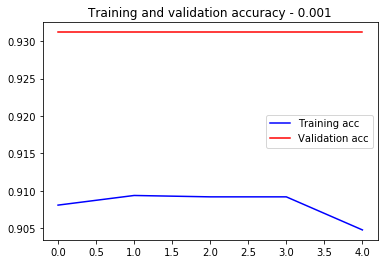

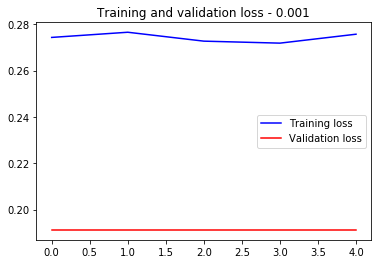

Epoch 1/5
170/170 [==============================] - ETA: 18:36 - loss: 0.2612 - acc: 0.90 - ETA: 13:59 - loss: 0.2096 - acc: 0.93 - ETA: 12:19 - loss: 0.2235 - acc: 0.90 - ETA: 11:29 - loss: 0.2503 - acc: 0.91 - ETA: 10:53 - loss: 0.2425 - acc: 0.91 - ETA: 10:27 - loss: 0.2653 - acc: 0.91 - ETA: 10:07 - loss: 0.2602 - acc: 0.91 - ETA: 9:51 - loss: 0.2506 - acc: 0.9219 - ETA: 9:37 - loss: 0.2425 - acc: 0.923 - ETA: 9:26 - loss: 0.2449 - acc: 0.921 - ETA: 9:17 - loss: 0.2398 - acc: 0.923 - ETA: 9:08 - loss: 0.2441 - acc: 0.921 - ETA: 9:02 - loss: 0.2665 - acc: 0.915 - ETA: 8:55 - loss: 0.2795 - acc: 0.917 - ETA: 8:49 - loss: 0.2729 - acc: 0.920 - ETA: 8:43 - loss: 0.2749 - acc: 0.921 - ETA: 8:37 - loss: 0.2687 - acc: 0.924 - ETA: 8:32 - loss: 0.2620 - acc: 0.927 - ETA: 8:26 - loss: 0.2752 - acc: 0.924 - ETA: 8:13 - loss: 0.2840 - acc: 0.922 - ETA: 8:09 - loss: 0.2849 - acc: 0.921 - ETA: 8:04 - loss: 0.2842 - acc: 0.920 - ETA: 8:00 - loss: 0.2826 - acc: 0.921 - ETA: 7:56 - loss: 0.2819 -

170/170 [==============================] - ETA: 9:13 - loss: 0.2078 - acc: 0.875 - ETA: 9:17 - loss: 0.1935 - acc: 0.921 - ETA: 9:13 - loss: 0.2591 - acc: 0.875 - ETA: 9:07 - loss: 0.2606 - acc: 0.890 - ETA: 9:01 - loss: 0.2521 - acc: 0.887 - ETA: 8:59 - loss: 0.2741 - acc: 0.880 - ETA: 8:55 - loss: 0.3031 - acc: 0.861 - ETA: 8:51 - loss: 0.3040 - acc: 0.867 - ETA: 8:46 - loss: 0.3083 - acc: 0.868 - ETA: 8:42 - loss: 0.2884 - acc: 0.881 - ETA: 8:37 - loss: 0.2931 - acc: 0.883 - ETA: 8:32 - loss: 0.2914 - acc: 0.885 - ETA: 8:27 - loss: 0.2825 - acc: 0.891 - ETA: 8:23 - loss: 0.2770 - acc: 0.895 - ETA: 8:18 - loss: 0.2759 - acc: 0.893 - ETA: 8:14 - loss: 0.2846 - acc: 0.892 - ETA: 8:10 - loss: 0.2767 - acc: 0.897 - ETA: 8:06 - loss: 0.2744 - acc: 0.895 - ETA: 8:02 - loss: 0.2733 - acc: 0.894 - ETA: 7:58 - loss: 0.2653 - acc: 0.900 - ETA: 7:54 - loss: 0.2652 - acc: 0.898 - ETA: 7:51 - loss: 0.2681 - acc: 0.897 - ETA: 7:47 - loss: 0.2689 - acc: 0.899 - ETA: 7:43 - loss: 0.2609 - acc: 0.903

170/170 [==============================] - ETA: 8:29 - loss: 0.1542 - acc: 0.968 - ETA: 8:42 - loss: 0.2499 - acc: 0.906 - ETA: 8:48 - loss: 0.2590 - acc: 0.895 - ETA: 8:47 - loss: 0.2694 - acc: 0.898 - ETA: 8:49 - loss: 0.2536 - acc: 0.906 - ETA: 8:45 - loss: 0.2570 - acc: 0.906 - ETA: 8:44 - loss: 0.2808 - acc: 0.901 - ETA: 8:42 - loss: 0.2567 - acc: 0.910 - ETA: 8:37 - loss: 0.2609 - acc: 0.906 - ETA: 8:33 - loss: 0.2795 - acc: 0.896 - ETA: 8:28 - loss: 0.2956 - acc: 0.889 - ETA: 8:24 - loss: 0.2976 - acc: 0.885 - ETA: 8:19 - loss: 0.3032 - acc: 0.879 - ETA: 8:15 - loss: 0.2976 - acc: 0.883 - ETA: 8:11 - loss: 0.2920 - acc: 0.885 - ETA: 8:08 - loss: 0.2909 - acc: 0.886 - ETA: 8:04 - loss: 0.2810 - acc: 0.891 - ETA: 7:51 - loss: 0.2903 - acc: 0.890 - ETA: 7:49 - loss: 0.2939 - acc: 0.889 - ETA: 7:46 - loss: 0.2985 - acc: 0.886 - ETA: 7:43 - loss: 0.2971 - acc: 0.887 - ETA: 7:40 - loss: 0.3026 - acc: 0.887 - ETA: 7:37 - loss: 0.3017 - acc: 0.890 - ETA: 7:35 - loss: 0.2975 - acc: 0.892

170/170 [==============================] - ETA: 8:48 - loss: 0.2236 - acc: 0.937 - ETA: 8:38 - loss: 0.2853 - acc: 0.921 - ETA: 8:45 - loss: 0.2655 - acc: 0.937 - ETA: 8:46 - loss: 0.2912 - acc: 0.929 - ETA: 8:46 - loss: 0.2870 - acc: 0.925 - ETA: 8:45 - loss: 0.2717 - acc: 0.927 - ETA: 8:44 - loss: 0.3008 - acc: 0.915 - ETA: 8:41 - loss: 0.3056 - acc: 0.906 - ETA: 8:39 - loss: 0.3008 - acc: 0.906 - ETA: 8:36 - loss: 0.2961 - acc: 0.909 - ETA: 8:34 - loss: 0.2939 - acc: 0.911 - ETA: 8:30 - loss: 0.2842 - acc: 0.914 - ETA: 8:25 - loss: 0.2792 - acc: 0.915 - ETA: 8:21 - loss: 0.2777 - acc: 0.915 - ETA: 8:16 - loss: 0.2824 - acc: 0.910 - ETA: 8:13 - loss: 0.2797 - acc: 0.914 - ETA: 8:09 - loss: 0.2797 - acc: 0.915 - ETA: 8:05 - loss: 0.2816 - acc: 0.914 - ETA: 8:02 - loss: 0.2788 - acc: 0.914 - ETA: 7:59 - loss: 0.2729 - acc: 0.917 - ETA: 7:55 - loss: 0.2805 - acc: 0.909 - ETA: 7:52 - loss: 0.2815 - acc: 0.907 - ETA: 7:48 - loss: 0.2800 - acc: 0.909 - ETA: 7:45 - loss: 0.2786 - acc: 0.907

170/170 [==============================] - ETA: 8:26 - loss: 0.1845 - acc: 0.906 - ETA: 8:26 - loss: 0.2442 - acc: 0.921 - ETA: 8:24 - loss: 0.2549 - acc: 0.916 - ETA: 8:30 - loss: 0.2481 - acc: 0.921 - ETA: 8:32 - loss: 0.2182 - acc: 0.931 - ETA: 8:33 - loss: 0.2185 - acc: 0.921 - ETA: 8:34 - loss: 0.2315 - acc: 0.919 - ETA: 8:33 - loss: 0.2477 - acc: 0.918 - ETA: 8:31 - loss: 0.2428 - acc: 0.920 - ETA: 8:29 - loss: 0.2412 - acc: 0.921 - ETA: 8:25 - loss: 0.2604 - acc: 0.911 - ETA: 8:21 - loss: 0.2599 - acc: 0.914 - ETA: 8:16 - loss: 0.2717 - acc: 0.911 - ETA: 8:13 - loss: 0.2676 - acc: 0.912 - ETA: 8:09 - loss: 0.2586 - acc: 0.916 - ETA: 8:06 - loss: 0.2545 - acc: 0.918 - ETA: 8:02 - loss: 0.2532 - acc: 0.919 - ETA: 7:59 - loss: 0.2577 - acc: 0.916 - ETA: 7:56 - loss: 0.2535 - acc: 0.917 - ETA: 7:52 - loss: 0.2524 - acc: 0.917 - ETA: 7:49 - loss: 0.2517 - acc: 0.919 - ETA: 7:45 - loss: 0.2527 - acc: 0.919 - ETA: 7:42 - loss: 0.2501 - acc: 0.921 - ETA: 7:38 - loss: 0.2496 - acc: 0.921

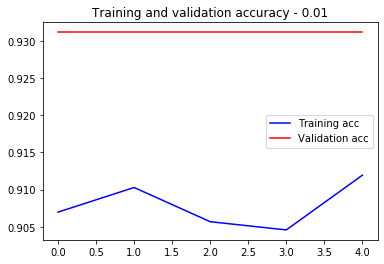

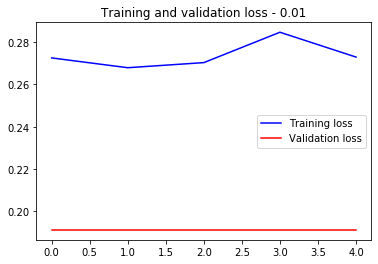

Epoch 1/5
170/170 [==============================] - ETA: 13:35 - loss: 0.4080 - acc: 0.87 - ETA: 11:36 - loss: 0.2908 - acc: 0.89 - ETA: 10:41 - loss: 0.3159 - acc: 0.87 - ETA: 10:15 - loss: 0.2992 - acc: 0.89 - ETA: 9:57 - loss: 0.3012 - acc: 0.9000 - ETA: 9:43 - loss: 0.2819 - acc: 0.906 - ETA: 9:30 - loss: 0.2808 - acc: 0.906 - ETA: 9:19 - loss: 0.2701 - acc: 0.910 - ETA: 9:10 - loss: 0.2695 - acc: 0.909 - ETA: 9:01 - loss: 0.2687 - acc: 0.909 - ETA: 8:54 - loss: 0.2610 - acc: 0.914 - ETA: 8:48 - loss: 0.2675 - acc: 0.914 - ETA: 8:42 - loss: 0.2645 - acc: 0.908 - ETA: 8:36 - loss: 0.2615 - acc: 0.908 - ETA: 8:31 - loss: 0.2570 - acc: 0.910 - ETA: 8:26 - loss: 0.2519 - acc: 0.916 - ETA: 8:21 - loss: 0.2486 - acc: 0.913 - ETA: 8:16 - loss: 0.2564 - acc: 0.909 - ETA: 8:12 - loss: 0.2592 - acc: 0.909 - ETA: 8:07 - loss: 0.2583 - acc: 0.907 - ETA: 8:03 - loss: 0.2550 - acc: 0.910 - ETA: 7:59 - loss: 0.2587 - acc: 0.909 - ETA: 7:55 - loss: 0.2512 - acc: 0.911 - ETA: 7:51 - loss: 0.2538 -

170/170 [==============================] - ETA: 8:58 - loss: 0.4039 - acc: 0.968 - ETA: 9:01 - loss: 0.3496 - acc: 0.937 - ETA: 9:01 - loss: 0.3421 - acc: 0.916 - ETA: 8:58 - loss: 0.3357 - acc: 0.914 - ETA: 8:54 - loss: 0.3195 - acc: 0.918 - ETA: 8:51 - loss: 0.3148 - acc: 0.911 - ETA: 8:46 - loss: 0.3211 - acc: 0.910 - ETA: 8:45 - loss: 0.3067 - acc: 0.918 - ETA: 8:44 - loss: 0.2976 - acc: 0.916 - ETA: 8:39 - loss: 0.2944 - acc: 0.915 - ETA: 8:34 - loss: 0.2769 - acc: 0.920 - ETA: 8:29 - loss: 0.2890 - acc: 0.919 - ETA: 8:25 - loss: 0.2873 - acc: 0.918 - ETA: 8:20 - loss: 0.2950 - acc: 0.915 - ETA: 8:17 - loss: 0.2966 - acc: 0.916 - ETA: 8:13 - loss: 0.2927 - acc: 0.918 - ETA: 8:09 - loss: 0.2824 - acc: 0.922 - ETA: 8:05 - loss: 0.2852 - acc: 0.918 - ETA: 8:02 - loss: 0.2783 - acc: 0.919 - ETA: 7:58 - loss: 0.2750 - acc: 0.920 - ETA: 7:54 - loss: 0.2707 - acc: 0.921 - ETA: 7:52 - loss: 0.2714 - acc: 0.920 - ETA: 7:49 - loss: 0.2745 - acc: 0.921 - ETA: 7:45 - loss: 0.2725 - acc: 0.920

170/170 [==============================] - ETA: 8:29 - loss: 0.3060 - acc: 0.906 - ETA: 8:51 - loss: 0.2917 - acc: 0.906 - ETA: 8:54 - loss: 0.2783 - acc: 0.906 - ETA: 8:51 - loss: 0.2580 - acc: 0.921 - ETA: 8:52 - loss: 0.2611 - acc: 0.918 - ETA: 8:48 - loss: 0.2571 - acc: 0.916 - ETA: 8:46 - loss: 0.2380 - acc: 0.924 - ETA: 8:45 - loss: 0.2900 - acc: 0.910 - ETA: 8:40 - loss: 0.3003 - acc: 0.906 - ETA: 8:35 - loss: 0.2949 - acc: 0.909 - ETA: 8:32 - loss: 0.3105 - acc: 0.903 - ETA: 8:28 - loss: 0.3037 - acc: 0.906 - ETA: 8:23 - loss: 0.2929 - acc: 0.908 - ETA: 8:20 - loss: 0.2889 - acc: 0.908 - ETA: 8:16 - loss: 0.2834 - acc: 0.912 - ETA: 8:12 - loss: 0.2829 - acc: 0.914 - ETA: 8:08 - loss: 0.2926 - acc: 0.909 - ETA: 8:04 - loss: 0.2876 - acc: 0.911 - ETA: 8:00 - loss: 0.2880 - acc: 0.911 - ETA: 7:56 - loss: 0.2794 - acc: 0.914 - ETA: 7:53 - loss: 0.2762 - acc: 0.915 - ETA: 7:49 - loss: 0.2824 - acc: 0.914 - ETA: 7:46 - loss: 0.2771 - acc: 0.917 - ETA: 7:42 - loss: 0.2700 - acc: 0.919

170/170 [==============================] - ETA: 8:38 - loss: 0.2882 - acc: 0.843 - ETA: 8:30 - loss: 0.3274 - acc: 0.843 - ETA: 8:38 - loss: 0.2469 - acc: 0.885 - ETA: 8:45 - loss: 0.2116 - acc: 0.906 - ETA: 8:46 - loss: 0.2163 - acc: 0.900 - ETA: 8:45 - loss: 0.2303 - acc: 0.901 - ETA: 8:42 - loss: 0.2523 - acc: 0.892 - ETA: 8:39 - loss: 0.2535 - acc: 0.898 - ETA: 8:38 - loss: 0.2659 - acc: 0.895 - ETA: 8:35 - loss: 0.2633 - acc: 0.900 - ETA: 8:31 - loss: 0.2611 - acc: 0.900 - ETA: 8:27 - loss: 0.2532 - acc: 0.903 - ETA: 8:23 - loss: 0.2745 - acc: 0.896 - ETA: 8:19 - loss: 0.2728 - acc: 0.897 - ETA: 8:15 - loss: 0.2674 - acc: 0.900 - ETA: 8:11 - loss: 0.2755 - acc: 0.896 - ETA: 8:07 - loss: 0.2773 - acc: 0.897 - ETA: 8:04 - loss: 0.2757 - acc: 0.899 - ETA: 8:00 - loss: 0.2856 - acc: 0.896 - ETA: 7:57 - loss: 0.2827 - acc: 0.896 - ETA: 7:53 - loss: 0.2813 - acc: 0.895 - ETA: 7:50 - loss: 0.2813 - acc: 0.896 - ETA: 7:47 - loss: 0.2784 - acc: 0.898 - ETA: 7:43 - loss: 0.2751 - acc: 0.901

170/170 [==============================] - ETA: 8:34 - loss: 0.2695 - acc: 0.875 - ETA: 8:31 - loss: 0.2112 - acc: 0.906 - ETA: 8:29 - loss: 0.2669 - acc: 0.906 - ETA: 8:36 - loss: 0.2931 - acc: 0.882 - ETA: 8:37 - loss: 0.2669 - acc: 0.893 - ETA: 8:40 - loss: 0.2720 - acc: 0.901 - ETA: 8:39 - loss: 0.2569 - acc: 0.906 - ETA: 8:41 - loss: 0.2466 - acc: 0.910 - ETA: 8:40 - loss: 0.2471 - acc: 0.916 - ETA: 8:39 - loss: 0.2419 - acc: 0.921 - ETA: 8:37 - loss: 0.2458 - acc: 0.917 - ETA: 8:32 - loss: 0.2559 - acc: 0.916 - ETA: 8:32 - loss: 0.2586 - acc: 0.913 - ETA: 8:28 - loss: 0.2487 - acc: 0.919 - ETA: 8:24 - loss: 0.2500 - acc: 0.918 - ETA: 8:19 - loss: 0.2447 - acc: 0.919 - ETA: 8:16 - loss: 0.2583 - acc: 0.917 - ETA: 8:13 - loss: 0.2575 - acc: 0.918 - ETA: 8:09 - loss: 0.2605 - acc: 0.917 - ETA: 8:06 - loss: 0.2627 - acc: 0.917 - ETA: 8:02 - loss: 0.2614 - acc: 0.916 - ETA: 7:59 - loss: 0.2581 - acc: 0.917 - ETA: 7:55 - loss: 0.2593 - acc: 0.917 - ETA: 7:52 - loss: 0.2580 - acc: 0.916

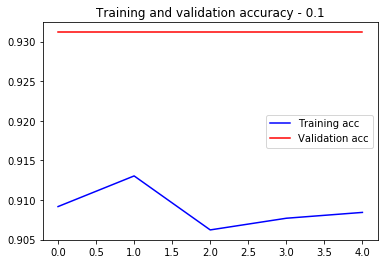

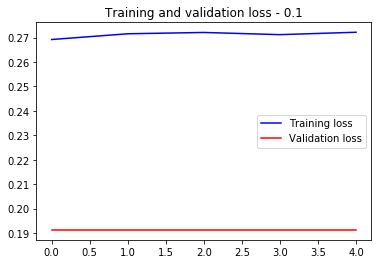

In [10]:
# Train Inception Model

pre_models = ['InceptionV3', 'VGG16']

for pre_model in pre_models:
    if pre_model == 'InceptionV3':
        # create the base pre-trained model
        base_model = InceptionV3(weights='imagenet', include_top=False)
    elif pre_model == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 8 classes
    predictions = Dense(9, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

    # performing data argumentation by training image generator
    dataAugmentation = ImageDataGenerator(rotation_range = 30, zoom_range = 0.20, 
    fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
    width_shift_range = 0.1, height_shift_range = 0.1)

    dataAugmentation.fit(X_train)

    # train the model on the new data for a few epochs
    model.fit_generator(dataAugmentation.flow(X_train, Y_train, batch_size = 32),
     validation_data = (X_valid, Y_valid), steps_per_epoch = len(X_train) // 32,
     epochs = 5)

    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from inception V3. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    ##for i, layer in enumerate(base_model.layers):
       ##print(i, layer.name)

    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:249]:
       layer.trainable = False
    for layer in model.layers[249:]:
       layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    from keras.optimizers import SGD
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    for learn_rate in learning_rates:
        model.compile(optimizer=SGD(lr=learn_rate, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

        # we train our model again (this time fine-tuning the top 2 inception blocks
        # alongside the top Dense layers
        train_incept = model.fit_generator(dataAugmentation.flow(X_train, Y_train, batch_size = 32),
         validation_data = (X_valid, Y_valid), steps_per_epoch = len(X_train) // 32,
         epochs = 5)

        #save the model
        save_model_name = 'retrained_' + str(pre_model) + '_lr_' + str(learn_rate) + '.h5'
        model.save(save_model_name)

        acc = train_incept.history['acc']
        val_acc = train_incept.history['val_acc']
        loss = train_incept.history['loss']
        val_loss = train_incept.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        title = 'Training and validation accuracy' + ' - ' + str(learn_rate)
        plt.title(title)
        plt.legend()

        plt.figure()

        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        title = 'Training and validation loss' + ' - ' + str(learn_rate)
        plt.title(title)
        plt.legend()

        plt.show()

In [17]:
# Train Inception Model
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 8 classes
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# performing data argumentation by training image generator
dataAugmentation = ImageDataGenerator(rotation_range = 30, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.1, height_shift_range = 0.1)

dataAugmentation.fit(X_train)

# train the model on the new data for a few epochs
model.fit_generator(dataAugmentation.flow(X_train, Y_train, batch_size = 32),
 validation_data = (X_valid, Y_valid), steps_per_epoch = len(X_train) // 32,
 epochs = 5)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(dataAugmentation.flow(X_train, Y_train, batch_size = 32),
 validation_data = (X_valid, Y_valid), steps_per_epoch = len(X_train) // 32,
 epochs = 5)

Epoch 1/5
170/170 [==============================] - ETA: 18:21 - loss: 2.2577 - acc: 0.25 - ETA: 13:45 - loss: 2.5588 - acc: 0.23 - ETA: 12:11 - loss: 2.4707 - acc: 0.21 - ETA: 11:25 - loss: 2.3481 - acc: 0.21 - ETA: 10:49 - loss: 2.3051 - acc: 0.20 - ETA: 10:24 - loss: 2.2553 - acc: 0.20 - ETA: 10:05 - loss: 2.1927 - acc: 0.22 - ETA: 9:51 - loss: 2.1699 - acc: 0.2227 - ETA: 9:39 - loss: 2.1470 - acc: 0.218 - ETA: 9:28 - loss: 2.1100 - acc: 0.231 - ETA: 9:19 - loss: 2.0851 - acc: 0.233 - ETA: 9:11 - loss: 2.0487 - acc: 0.255 - ETA: 9:04 - loss: 2.0223 - acc: 0.262 - ETA: 8:58 - loss: 2.0021 - acc: 0.272 - ETA: 8:52 - loss: 1.9943 - acc: 0.268 - ETA: 8:47 - loss: 1.9640 - acc: 0.277 - ETA: 8:41 - loss: 1.9437 - acc: 0.286 - ETA: 8:36 - loss: 1.9306 - acc: 0.288 - ETA: 8:31 - loss: 1.9147 - acc: 0.297 - ETA: 8:26 - loss: 1.9074 - acc: 0.300 - ETA: 8:21 - loss: 1.8875 - acc: 0.309 - ETA: 8:16 - loss: 1.8638 - acc: 0.321 - ETA: 8:05 - loss: 1.8504 - acc: 0.321 - ETA: 8:01 - loss: 1.8353 -

170/170 [==============================] - ETA: 8:39 - loss: 0.3681 - acc: 0.906 - ETA: 9:00 - loss: 0.4976 - acc: 0.843 - ETA: 9:00 - loss: 0.5193 - acc: 0.833 - ETA: 8:58 - loss: 0.4760 - acc: 0.843 - ETA: 8:59 - loss: 0.4471 - acc: 0.856 - ETA: 8:59 - loss: 0.5512 - acc: 0.817 - ETA: 8:56 - loss: 0.5762 - acc: 0.812 - ETA: 8:54 - loss: 0.5918 - acc: 0.808 - ETA: 8:50 - loss: 0.5839 - acc: 0.812 - ETA: 8:45 - loss: 0.6030 - acc: 0.796 - ETA: 8:41 - loss: 0.6012 - acc: 0.798 - ETA: 8:37 - loss: 0.5914 - acc: 0.799 - ETA: 8:32 - loss: 0.5684 - acc: 0.807 - ETA: 8:28 - loss: 0.5541 - acc: 0.812 - ETA: 8:24 - loss: 0.5490 - acc: 0.818 - ETA: 8:20 - loss: 0.5518 - acc: 0.818 - ETA: 8:16 - loss: 0.5534 - acc: 0.818 - ETA: 8:12 - loss: 0.5547 - acc: 0.817 - ETA: 8:08 - loss: 0.5591 - acc: 0.817 - ETA: 8:04 - loss: 0.5522 - acc: 0.820 - ETA: 8:01 - loss: 0.5576 - acc: 0.819 - ETA: 7:58 - loss: 0.5528 - acc: 0.823 - ETA: 7:54 - loss: 0.5581 - acc: 0.822 - ETA: 7:51 - loss: 0.5512 - acc: 0.822

170/170 [==============================] - ETA: 8:36 - loss: 0.4234 - acc: 0.843 - ETA: 8:38 - loss: 0.4042 - acc: 0.828 - ETA: 8:39 - loss: 0.4270 - acc: 0.812 - ETA: 8:47 - loss: 0.3836 - acc: 0.835 - ETA: 8:49 - loss: 0.3657 - acc: 0.850 - ETA: 8:50 - loss: 0.3517 - acc: 0.859 - ETA: 8:48 - loss: 0.3433 - acc: 0.861 - ETA: 8:47 - loss: 0.3183 - acc: 0.878 - ETA: 8:43 - loss: 0.3196 - acc: 0.878 - ETA: 8:41 - loss: 0.3214 - acc: 0.881 - ETA: 8:39 - loss: 0.3244 - acc: 0.880 - ETA: 8:35 - loss: 0.3279 - acc: 0.880 - ETA: 8:32 - loss: 0.3337 - acc: 0.877 - ETA: 8:28 - loss: 0.3434 - acc: 0.870 - ETA: 8:24 - loss: 0.3563 - acc: 0.862 - ETA: 8:21 - loss: 0.3531 - acc: 0.867 - ETA: 8:17 - loss: 0.3735 - acc: 0.860 - ETA: 8:13 - loss: 0.3711 - acc: 0.861 - ETA: 8:09 - loss: 0.3582 - acc: 0.868 - ETA: 8:06 - loss: 0.3659 - acc: 0.867 - ETA: 8:02 - loss: 0.3669 - acc: 0.867 - ETA: 7:58 - loss: 0.3594 - acc: 0.872 - ETA: 7:55 - loss: 0.3560 - acc: 0.875 - ETA: 7:51 - loss: 0.3632 - acc: 0.875

 39/170 [=====>........................] - ETA: 27:39 - loss: 0.3499 - acc: 0.87 - ETA: 27:23 - loss: 0.3226 - acc: 0.89 - ETA: 26:58 - loss: 0.2988 - acc: 0.89 - ETA: 26:40 - loss: 0.3026 - acc: 0.89 - ETA: 26:36 - loss: 0.2850 - acc: 0.90 - ETA: 26:20 - loss: 0.2837 - acc: 0.90 - ETA: 26:06 - loss: 0.2782 - acc: 0.90 - ETA: 25:47 - loss: 0.2865 - acc: 0.90 - ETA: 25:35 - loss: 0.2841 - acc: 0.90 - ETA: 25:21 - loss: 0.3035 - acc: 0.89 - ETA: 25:07 - loss: 0.2989 - acc: 0.89 - ETA: 24:53 - loss: 0.2967 - acc: 0.89 - ETA: 24:41 - loss: 0.2863 - acc: 0.90 - ETA: 24:29 - loss: 0.2779 - acc: 0.90 - ETA: 24:17 - loss: 0.2681 - acc: 0.90 - ETA: 24:06 - loss: 0.2675 - acc: 0.90 - ETA: 23:55 - loss: 0.2542 - acc: 0.91 - ETA: 23:44 - loss: 0.2514 - acc: 0.91 - ETA: 23:33 - loss: 0.2446 - acc: 0.91 - ETA: 23:22 - loss: 0.2463 - acc: 0.91 - ETA: 23:12 - loss: 0.2451 - acc: 0.91 - ETA: 23:01 - loss: 0.2443 - acc: 0.91 - ETA: 22:50 - loss: 0.2424 - acc: 0.91 - ETA: 22:41 - loss: 0.2392 - acc: 0.92

KeyboardInterrupt: 

In [ ]:
df_img_size
#Images are of different shapes

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    print(nunique)
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: /kaggle/input/actions/dataset.csv

In [ ]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# dataset.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/kaggle/input/actions (2)/actions/dataset.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'dataset.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

In [ ]:
df1.head()

Let's take a quick look at what the data looks like:

In [0]:
df1.head(5)

Distribution graphs (histogram/bar graph) of sampled columns:

In [ ]:
plotPerColumnDistribution(df1, 10, 5)

## Conclusion
This concludes your starter analysis! To go forward from here, click the blue "Fork Notebook" button at the top of this kernel. This will create a copy of the code and environment for you to edit. Delete, modify, and add code as you please. Happy Kaggling!